In [1]:
import datetime as dt
import numpy as np
import xarray as xr

import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
import subprocess
from joblib import Parallel, delayed
import dask.array as da
from scipy.stats import spearmanr
import seaborn as sns
import regionmask
import warnings
import cartopy.feature as cfeature
warnings.filterwarnings("ignore")
import matplotlib.colors as mcolors
import xskillscore as xs

In [2]:
#make a download directory
import os
if not os.path.exists('download'):
    os.makedirs('download')
if not os.path.exists('figures/rpss'):
    os.makedirs('figures/rpss')
if not os.path.exists('data'):
    os.makedirs('data')

os.makedirs('figures/rpss/precip', exist_ok=True)
os.makedirs('figures/rpss/spi', exist_ok=True)

In [3]:
download = False

## Load Data

In [4]:
cfsv2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cfsv2_path = 'download/cfsv2_precip.nc'

gfdlspear_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.GFDL-SPEAR/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
gfdlspear_path = 'download/gfdlspear_precip.nc'

cansipsic4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.CanSIPS-IC4/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cansipsic4_path = 'download/cansipsic4_precip.nc'

cesm1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CESM1/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cesm1_path = 'download/cesm1_precip.nc'

colaccsm4_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.COLA-RSMAS-CCSM4/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
colaccsm4_path = 'download/colaccsm4_precip.nc'

nasageos1_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.HINDCAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos1_path = 'download/nasageos1_precip.nc'
nasageos2_url = "https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NASA-GEOSS2S/.FORECAST/.MONTHLY/.prec/Y/12/37/RANGE/X/32/60/RANGE/S/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
nasageos2_path = 'download/nasageos2_precip.nc'

if download:
    print(cfsv2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cfsv2_url, '-o', cfsv2_path])
    print(gfdlspear_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', gfdlspear_url, '-o', gfdlspear_path])
    print(cesm1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', cesm1_url, '-o', cesm1_path])
    print(colaccsm4_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', colaccsm4_url, '-o', colaccsm4_path])
    print(nasageos1_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos1_url, '-o', nasageos1_path])
    print(nasageos2_url)
    subprocess.call(['curl', '-b', 'cookies.txt', '-k', nasageos2_url, '-o', nasageos2_path])
    #print(cansipsic4_url)
    #subprocess.call(['curl', '-b', 'cookies.txt', '-k', cansipsic4_url, '-o', cansipsic4_path])
    

In [5]:
cfsv2 = xr.open_dataset(cfsv2_path, decode_times=True)
gfdlspear = xr.open_dataset(gfdlspear_path, decode_times=True)
cesm1 = xr.open_dataset(cesm1_path, decode_times=True)
colaccsm4 = xr.open_dataset(colaccsm4_path, decode_times=True)
nasageos = xr.open_dataset(nasageos1_path, decode_times=True)
nasageos2 = xr.open_dataset(nasageos2_path, decode_times=True).isel(M=slice(0, 4))
#concatenate the two nasageos datasets
nasageos = xr.concat([nasageos, nasageos2], dim='S')
#cansipsic4 = xr.open_dataset(cansipsic4_path, decode_times=True)

In [6]:
cmap_url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc"
cmap_path = 'download/cmap_precip.nc'

print(cmap_url)
subprocess.call(['curl', '-b', 'cookies.txt', '-k', cmap_url, '-o', cmap_path])

cmap = xr.open_dataset(cmap_path, decode_times=True)
#change datetime to 01-MM-YYYY
new_dates = pd.to_datetime(cmap['T'].values, format="%d-%m-%Y").strftime("01-%m-%Y")
cmap['T'] = pd.to_datetime(new_dates, format="%d-%m-%Y")
obs = cmap['prcp_est']

obs_3m = obs + obs.shift(T=1) + obs.shift(T=2)
obs_3m = obs_3m.dropna('T')


https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver1/.prcp_est/X/-180/1/179/GRID/Y/-90/1/90/GRID/Y/12/37/RANGE/X/32/60/RANGE/T/(days%20since%201960-01-01)/streamgridunitconvert/data.nc


In [7]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')

In [8]:
n_lead = 6

In [9]:
nmme_dict =  {'cfsv2': cfsv2, 'gfdlspear': gfdlspear, 'cesm1': cesm1, 'colaccsm4': colaccsm4, 'nasageos': nasageos}

precip_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}
spi_fcast_dict = {'cfsv2': None, 'gfdlspear': None, 'cesm1': None, 'colaccsm4': None, 'nasageos': None}

In [10]:
# First, concatenate all members from all NMME models
print("Concatenating all NMME members...")
all_nmme_data = []
all_member_names = []

for (nmme_name, nmme) in nmme_dict.items():
    print(f"Adding members from {nmme_name}")
    # Add model name to member names for identification
    members = nmme['M'].values
    for member in members:
        member_id = f"{nmme_name}_{member}"
        all_member_names.append(member_id)
        all_nmme_data.append(nmme.sel(M=member))

# Concatenate all members across models
print(f"Total members across all models: {len(all_member_names)}")
combined_nmme = xr.concat(all_nmme_data, dim='M')
combined_nmme = combined_nmme.assign_coords(M=all_member_names)

total_members = len(all_member_names)


Concatenating all NMME members...
Adding members from cfsv2
Adding members from gfdlspear
Adding members from cesm1
Adding members from colaccsm4
Adding members from nasageos
Total members across all models: 67


# Skill

In [11]:
spi_obs = xr.load_dataset('../data/spi3_cmap_1x1.nc')
#rename variable __xarray_dataarray_variable__ to spi
spi_obs = spi_obs.rename({'__xarray_dataarray_variable__':'spi'}).spi.sortby('T')


# RPSS Precip

In [12]:
# compute month-specific quantiles (per gridpoint)
q33 = obs_3m.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.33, dim='T')
q67 = obs_3m.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

precip_cat = obs_3m.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
precip_cat = precip_cat.where(~np.isnan(obs_3m))

In [13]:
mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask( spi_obs['X'], spi_obs['Y'])

In [43]:
import xskillscore as xs

def rps_score(probs, outcomes):
    N, K = probs.shape
    #create nan edge case
    if np.all(np.isnan(probs)) or np.all(np.isnan(outcomes)):
        return np.nan

    # One-hot encode outcomes
    one_hot = np.zeros((N, K))
    one_hot[np.arange(N), outcomes.astype(int)] = 1

    # Cumulative sums across categories
    cum_probs = np.cumsum(probs, axis=1)
    cum_outcomes = np.cumsum(one_hot, axis=1)

    # Squared differences
    diffs = (cum_probs - cum_outcomes) ** 2

    # Sum over categories and average over cases
    rps_vals = diffs.sum(axis=1) 
    return rps_vals.mean()


def compute_rpss(obs, fcst):
    n_cat = 3
    ref_probs = np.ones(n_cat) / n_cat

    results = []
    ohe_obs_list = []
    forecast_list = []

    for s_month in range(1, 13):  # start months
        for lead_time in [2.5]:

            # Forecasts for given start month and lead
            fcst_sel = fcst.sel(S=fcst['S.month'] == s_month).sel(L=lead_time) #.transpose('S', 'Y', 'X', 'category')

            fcst_sel = fcst_sel + fcst.sel(S=fcst['S.month'] == s_month).sel(L=lead_time-1) + fcst.sel(S=fcst['S.month'] == s_month).sel(L=lead_time-2)
            t_month = (s_month + lead_time) % 12
            t_month = 12 if t_month == 0 else t_month

            # Convert S→T
            S_values = fcst_sel['S'].values
            T_values = [pd.Timestamp(s) + pd.DateOffset(months=(lead_time-0.5)) for s in S_values]
            fcst_sel['S'] = T_values
            fcst_month = fcst_sel.rename({'S': 'T'})

            q33 = fcst_month.quantile(0.33, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q67 = fcst_month.quantile(0.67, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q33_b = q33.broadcast_like(fcst_month)
            q67_b = q67.broadcast_like(fcst_month)

            # Boolean masks
            mask_below = fcst_month < q33_b
            mask_near  = (fcst_month >= q33_b) & (fcst_month <= q67_b)
            mask_above = fcst_month > q67_b

            # Compute probabilities over ensemble
            below = mask_below.mean(dim="M", skipna=True)
            near  = mask_near.mean(dim="M", skipna=True)
            above = mask_above.mean(dim="M", skipna=True)

            # Combine into Cat dimension
            prob= xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])

            # Matching obs
            obs_month = obs.sel(T=prob['T'])
            #give same NA
            prob = prob.where(obs_month.notnull(), drop=False).transpose('T', 'Y', 'X', 'category')
            prob = prob.where(mask==0)

            # Reference RPS (climatology)
            ref_probs_da = xr.DataArray(ref_probs, dims=["category"])
            ref_probs_broadcast = ref_probs_da.broadcast_like(prob)

            ohe_obs = xr.concat(
            [
            (obs_month == 0).assign_coords(category=0),
            (obs_month == 1).assign_coords(category=1),
            (obs_month == 2).assign_coords(category=2),
            ],dim='category').where(obs_month.notnull()).transpose('T', 'Y', 'X', 'category')

            rps_vals = xs.rps(ohe_obs, prob, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs, ref_probs_broadcast, dim="T", category_edges=None, input_distributions="p")

            # RPSS directly (no mean over T outside)
            rpss = 1 - (rps_vals / ref_rps_vals)

            results.append(
                rpss.expand_dims({"L": [lead_time], "Smonth": [s_month]})
            )
            ohe_obs_list.append(ohe_obs.expand_dims({"L": [lead_time], "Smonth": [s_month]}))
            forecast_list.append(prob.expand_dims({"L": [lead_time], "Smonth": [s_month]}))


    rpss_final = xr.combine_by_coords(results)
    rpss_final = rpss_final.where(mask==0)
    ohe_obs_final = xr.concat(ohe_obs_list, dim='T').sortby('T')
    forecast_final = xr.concat(forecast_list, dim='T').sortby('T')
     
    return rpss_final, ohe_obs_final, forecast_final

rpss_final_precip, ohe_obs_final_precip, forecast_final_precip = compute_rpss(precip_cat, combined_nmme.prec.sel(S=slice('1991-01-01','2020-12-31'), L=slice(0.5,5.5)))


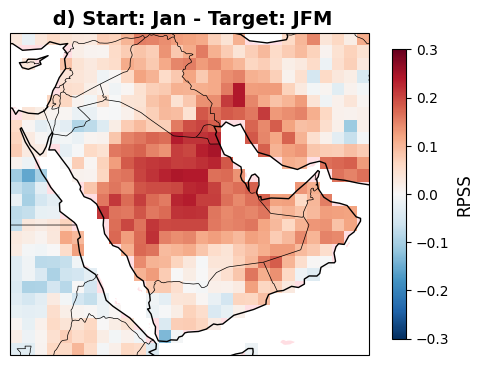

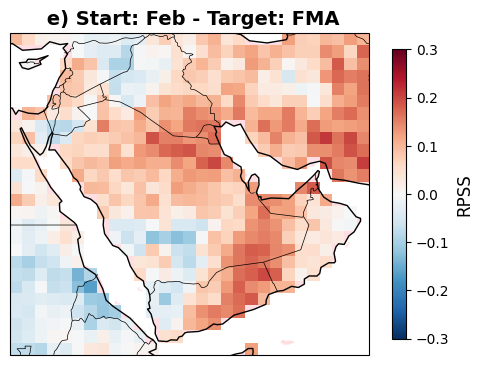

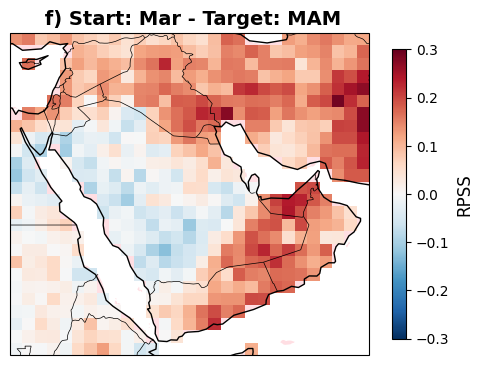

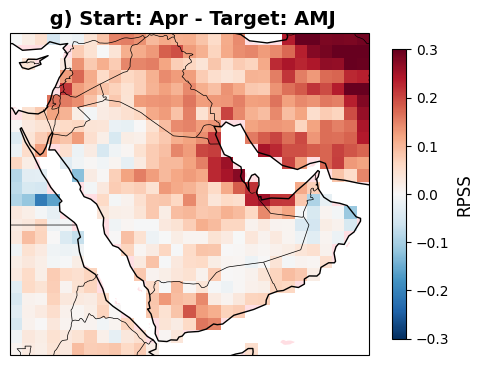

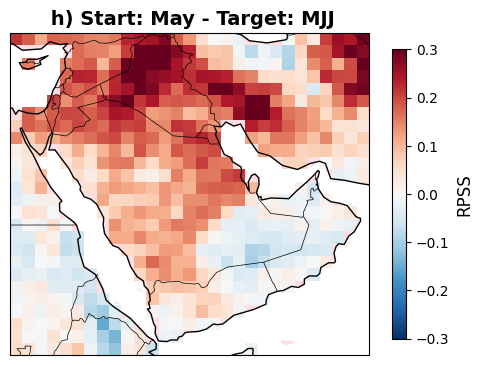

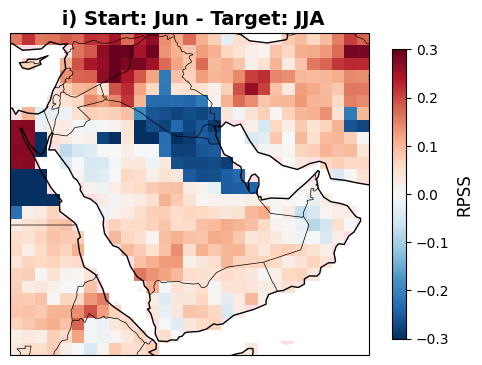

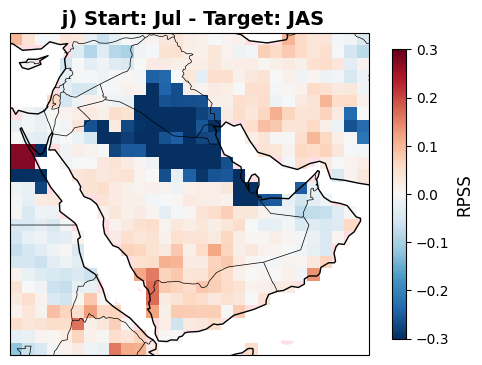

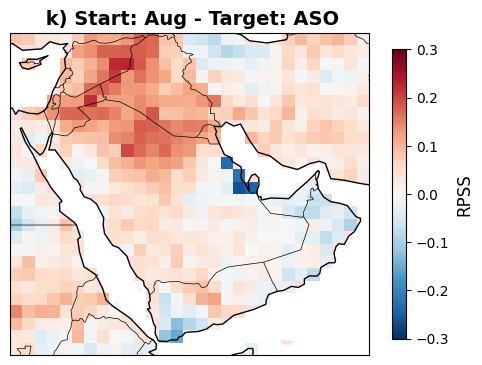

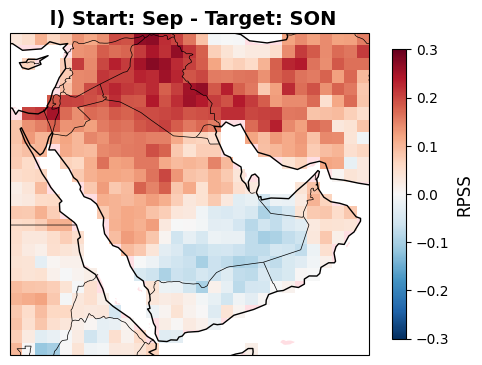

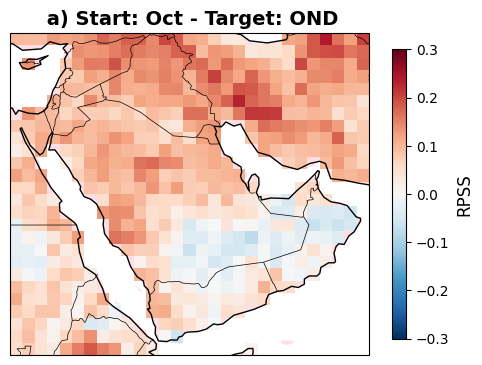

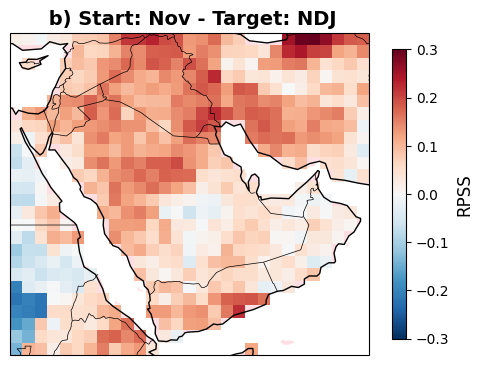

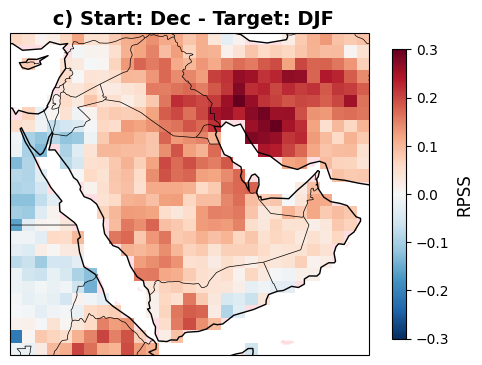

In [45]:

L = 2.5
for month in range(1, 13):
    seasons_to_month = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                        7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

    start = seasons_to_month[month]
    target_num = month + (L - 0.5)
    if target_num > 12:
        target_num -= 12

    month_to_season = {1: "NDJ", 2: "DJF", 3: "JFM", 4: "FMA", 5: "MAM", 6: "AMJ",
                       7: "MJJ", 8: "JJA", 9: "JAS", 10: "ASO", 11: "SON", 12: "OND"}
    
    season_to_label = {"OND": "a)", "NDJ": "b)", "DJF": "c)", "JFM": "d)", "FMA": "e)", "MAM": "f)",
                       "AMJ": "g)", "MJJ": "h)", "JJA": "i)", "JAS": "j)", "ASO": "k)", "SON": "l)"}
    
    target = month_to_season[target_num]
    
    label = season_to_label[target]
    
    title_str = f" {label} Start: {start} - Target: {target}"

    rpss_final_sel = rpss_final_precip.sel(Smonth=month, L=L)
    fig, ax = plt.subplots(
            figsize=(5, 4),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )

    im = rpss_final_sel.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.3, vmax=0.3,
            add_colorbar=False
        )

    
    # add coastlines, borders, land
    ax.coastlines(resolution="110m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

    # titles
    plt.title(f"{title_str}", fontsize=14, fontweight='bold')

    # colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.8)
    cbar.set_label("RPSS", fontsize=12)

    plt.tight_layout()
    plt.show()
        # save
    fig.savefig(
        f"figures/rpss/precip/start{start}_target{target}.pdf",
        dpi=150, bbox_inches="tight"
    )



# Reliability Precip

In [49]:
os.makedirs('figures/reliability/precip', exist_ok=True)

In [50]:
from matplotlib.patches import Patch, Polygon
from operator import sub
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader


def compute_reliability_score(y_true, y_pred, num_bins=10):
    """
    Compute the reliability score for probabilistic forecasts.

    Parameters:
    y_true (numpy array): Array of true binary outcomes (0 or 1).
    y_pred (numpy array): Array of predicted probabilities (between 0 and 1).
    num_bins (int): Number of bins to use for grouping predicted probabilities.

    Returns:
    float: The reliability score.
    """
    
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Initialize arrays to hold the average predicted probabilities and observed frequencies for each bin
    bin_avg_pred = np.zeros(num_bins)
    bin_avg_true = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)
    
    # Bin edges
    bin_edges = np.linspace(0, 1, num_bins + 1)
    
    # Assign each prediction to a bin
    bin_indices = np.digitize(y_pred, bin_edges, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are within valid range
    
    # Calculate bin statistics
    for i in range(num_bins):
        # Indices of predictions in the current bin
        bin_mask = (bin_indices == i)
        bin_count = np.sum(bin_mask)
        
        if bin_count > 0:
            # Average predicted probability for the current bin
            bin_avg_pred[i] = np.mean(y_pred[bin_mask])
            # Observed frequency (empirical probability) for the current bin
            bin_avg_true[i] = np.mean(y_true[bin_mask])
            bin_counts[i] = bin_count
    
    # Calculate the reliability score
    reliability_score = np.nansum((bin_avg_pred - bin_avg_true)**2 * bin_counts) / np.sum(bin_counts)
    
    return reliability_score

def compute_brier_skill_score(y_pred, t):
    """
    Compute the Brier Skill Score (BSS) for probabilistic forecasts.

    Parameters:
    y_pred (numpy array): Predicted probabilities.
    t (numpy array): True binary outcomes (0 or 1).

    Returns:
    float: The Brier Skill Score (BSS).
    """
    # Adjust y_pred to avoid edge cases
    y_pred = y_pred * 0.9999999999999
    
    # Mask to remove NaNs
    msk = np.where(~np.isnan(y_pred + t))
    y_pred = y_pred[msk]
    t = t[msk]
    
    # Calculate the base rate (climatological mean)
    base_rate = np.nanmean(t)
    base_rate = np.ones_like(np.nanmean(t)) * 1/3
    
    # Calculate the Brier Score (BS)
    bs = np.nanmean((y_pred - t)**2)
    
    # Calculate the Brier Score for the reference forecast (BR)
    br = np.nanmean((base_rate - t)**2)
    
    # Calculate the Brier Skill Score (BSS)
    bss = 1 - (bs / br)
    
    return bss

def compute_resolution_score(predictions, observations, num_bins=10):
    """
    Compute the resolution score for probabilistic forecasts.

    Parameters:
    predictions (numpy array): Predicted probabilities.
    observations (numpy array): True binary outcomes (0 or 1).
    num_bins (int): Number of bins to use for grouping predicted probabilities.

    Returns:
    float: The resolution score.
    """
    # Adjust predictions to avoid edge cases
    predictions = predictions * 0.9999999999999
    
    # Mask to remove NaNs
    mask = np.where(~np.isnan(predictions + observations))
    predictions = predictions[mask]
    observations = observations[mask]
    
    # Calculate the base rate (climatological mean)
    base_rate = np.nanmean(observations)
    
    # Initialize arrays to hold the average observed frequencies and counts for each bin
    bin_obs_freq = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)
    
    # Bin edges
    bin_edges = np.linspace(0, 1, num_bins + 1)
    
    # Assign each prediction to a bin
    bin_indices = np.digitize(predictions, bin_edges, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are within valid range
    
    # Calculate bin statistics
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_counts[i] = bin_mask.sum()
        
        if bin_counts[i] > 0:
            bin_obs_freq[i] = observations[bin_mask].mean()
    
    # Calculate the resolution score
    resolution = np.nansum(bin_counts * (bin_obs_freq - base_rate)**2) / np.sum(bin_counts)
    
    return resolution

def reliability_diagram(ypred, t, title=None, perfect_reliability_line=True, plot_hist=True, fig=None, ax=None, bin_minimum_pct=0.01, tercile_skill_area=True, scores=True,
                        save_name=None):
    """
    Compute and plot a reliability diagram (calibration curve) with a normalized histogram of the forecast probabilities.

    Parameters:
    ypred (numpy array): Predicted probabilities.
    t (numpy array): True binary outcomes (0 or 1).
    title (str): Title for the plot.
    perfect_reliability_line (bool): Whether to plot the perfect reliability line.
    plot_hist (bool): Whether to plot the histogram of forecast probabilities.
    fig (matplotlib Figure): Figure object to plot on.
    ax (matplotlib Axes): Axes object to plot on.
    bin_minimum_pct (float): Minimum percentage of samples in a bin to include it in the plot.
    """


    ypred = ypred * 0.9999999999999  # Avoids edge cases with digitize
    assert ypred.shape == t.shape, 'Inconsistent shapes between ypred and t - {} vs {}'.format(ypred.shape, t.shape)

    # Mask to remove NaNs
    msk = np.where(~np.isnan(ypred + t))
    ypred = ypred[msk]
    t = t[msk]

    # Total number of non-NaN samples
    countnonnan = np.ones_like(ypred).sum()

    # Initialize arrays
    bin_avg_pred = np.zeros(10)
    bin_obs_freq = np.zeros(10)
    bin_counts = np.zeros(10)

    # Iterate over bins
    for i in range(10):
        bin_mask = (ypred >= i / 10.0) & (ypred < (i / 10.0 + 0.1))
        bin_counts[i] = bin_mask.sum()
        
        if bin_counts[i] > 0:
            bin_avg_pred[i] = ypred[bin_mask].mean()
            bin_obs_freq[i] = t[bin_mask].mean()

    # Compute bin centers
    bin_centers = (np.arange(10) + 0.5) / 10.0

    # Mask bins with insufficient data
    valid_bins = bin_counts / countnonnan >= bin_minimum_pct
    bin_centers = bin_centers[valid_bins]
    bin_avg_pred = bin_avg_pred[valid_bins]
    bin_obs_freq = bin_obs_freq[valid_bins]
    bin_counts = bin_counts[valid_bins]

    # Normalize bin counts for the histogram
    bin_counts = bin_counts / countnonnan

    if ax is None:
        fig, ax = plt.subplots()

    b1, t1 = ax.set_ylim(0, 1)
    l, r = ax.set_xlim(0, 1)

    #plt.hist(epoelm_xval[:, 0], bins=11)
    if tercile_skill_area:
        ur = Polygon([[0.33, 0.33 ], [0.33, 1], [1,1], [1, 1.33/2.0]], facecolor='gray', alpha=0.25)
        bl = Polygon([[0.33, 0.33 ], [0.33, 0], [0,0], [0, 0.33/2.0]], facecolor='gray', alpha=0.25)
        ax.add_patch(ur)
        ax.add_patch(bl)

        ax.text(0.66, 0.28, 'No Resolution')
        noresolution = ax.plot([0, 1], [0.33,0.33], lw=0.5, linestyle='dotted')

        noskill = ax.plot([0, 1], [0.33/2.0,1.33/2.0], lw=0.5, linestyle='dotted')
        figW, figH = ax.get_figure().get_size_inches()
        _, _, w, h = ax.get_position().bounds
        disp_ratio = (figH * h) / (figW * w)
        data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())
        angle = (180.0/np.pi)*np.arctan(disp_ratio / data_ratio)
        ax.text(0.66, 0.45, 'No Skill', rotation=angle*0.5)

        ax.plot([0.33, 0.33], [0,1], lw=0.5, linestyle='dotted')

    # Plot the reliability diagram
    ax.plot(bin_centers, bin_obs_freq, marker='o', linestyle='-', color='darksalmon', label='Observed Frequency')

    # Plot the perfect reliability line
    if perfect_reliability_line:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Reliability')

    # Plot normalized histogram
    if plot_hist:
        ax.bar(bin_centers, bin_counts, width=0.1, color='tab:blue', alpha=0.5, label='Normalized Counts')

    if scores:
        bss = compute_brier_skill_score(ypred, t)
        rel = compute_reliability_score(t, ypred)
        res = compute_resolution_score(ypred, t)
        ax.text( 0.7, 0.11, 'BSS: {:0.04f}'.format(bss), fontdict={'size': 11})
        ax.text( 0.7, 0.06, 'REL: {:0.04f}'.format(rel), fontdict={'size': 11})
        ax.text( 0.7, 0.01, 'RES: {:0.04f}'.format(res), fontdict={'size': 11})

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    if title is not None:
        ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    if save_name is not None:
        plt.savefig(f'figures/reliability/precip/{save_name}.pdf', dpi=150, bbox_inches="tight")

    plt.show()

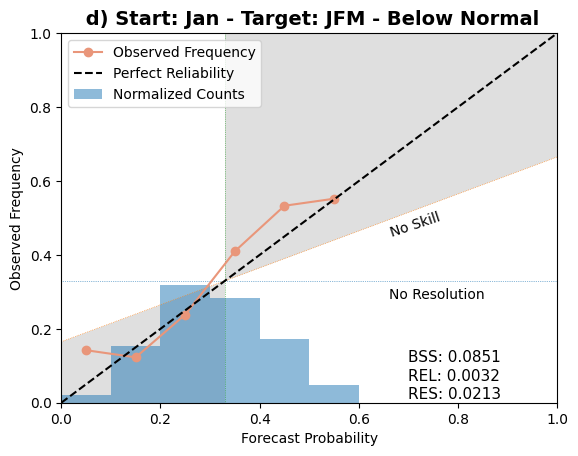

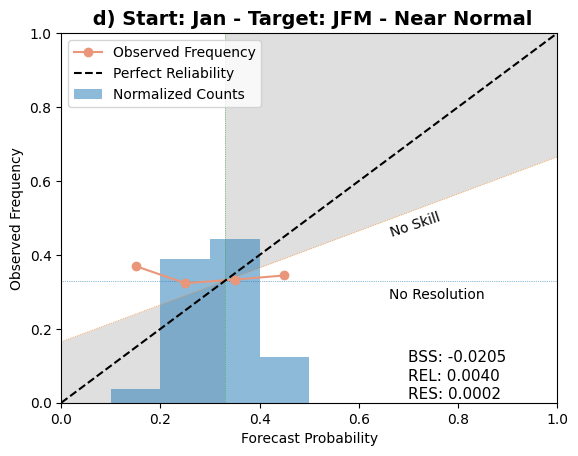

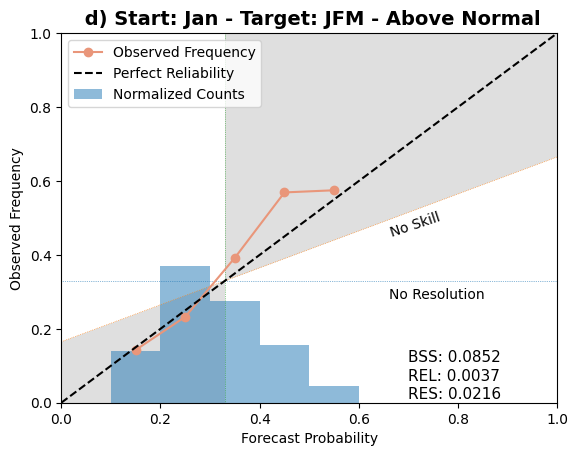

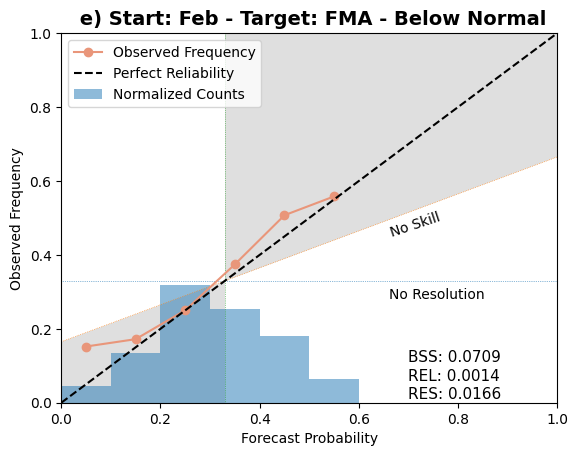

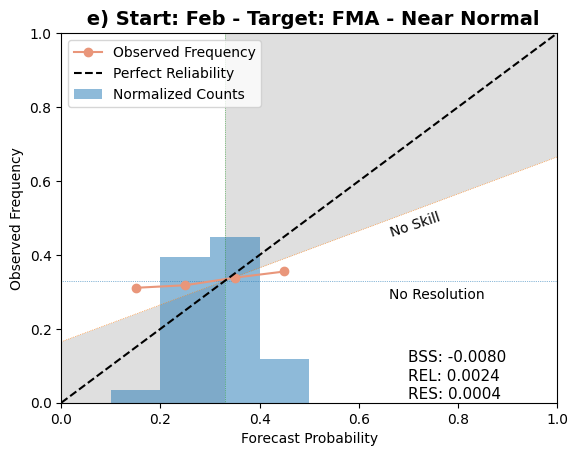

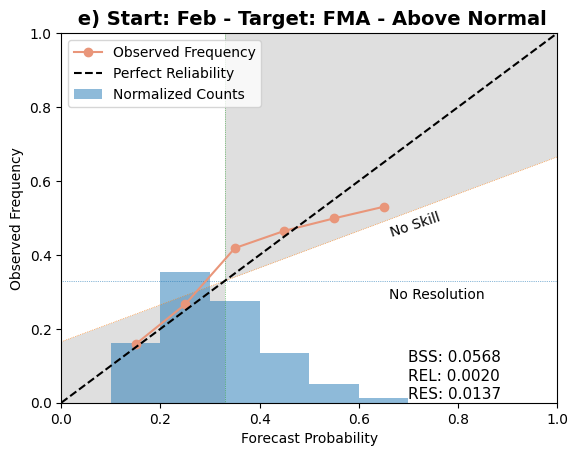

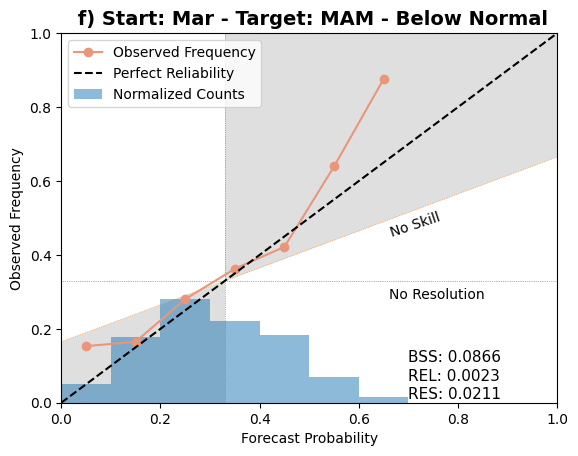

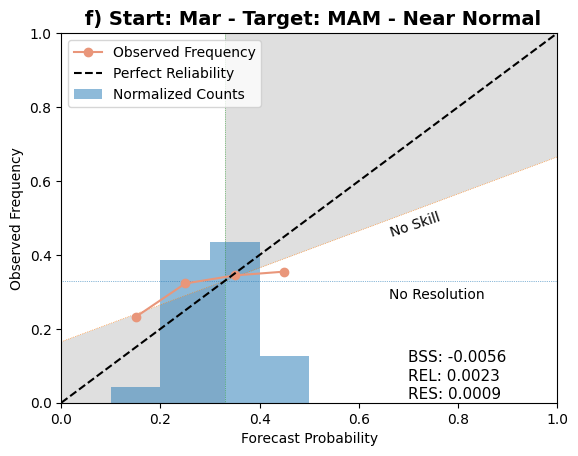

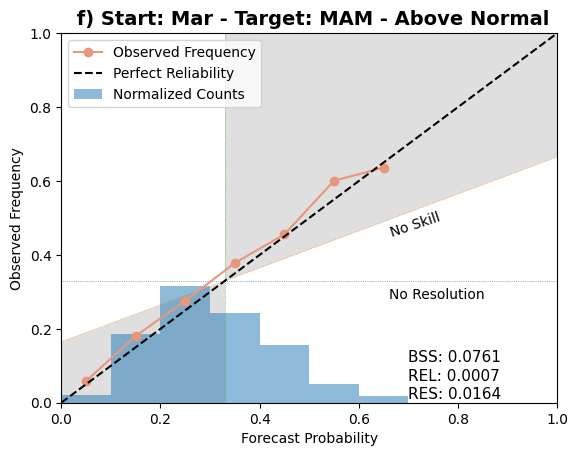

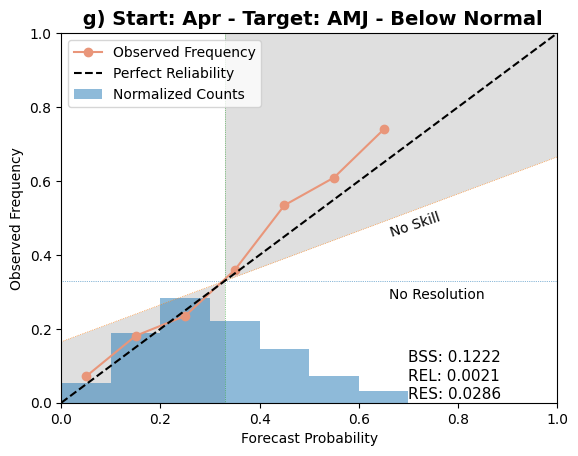

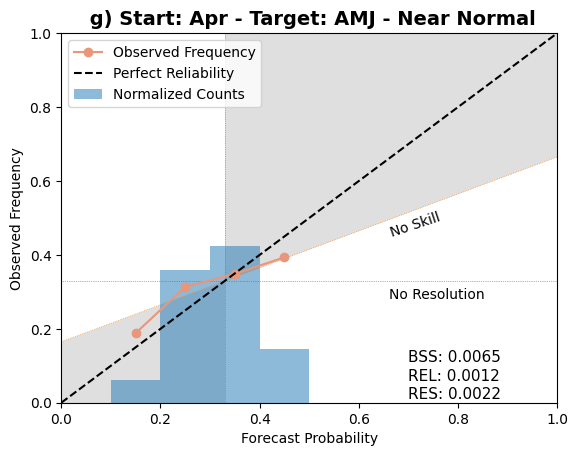

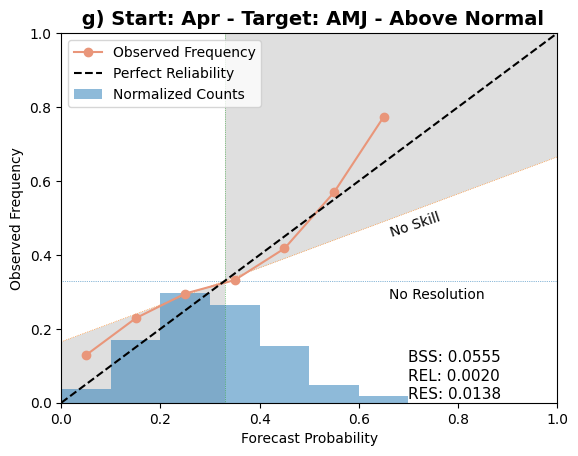

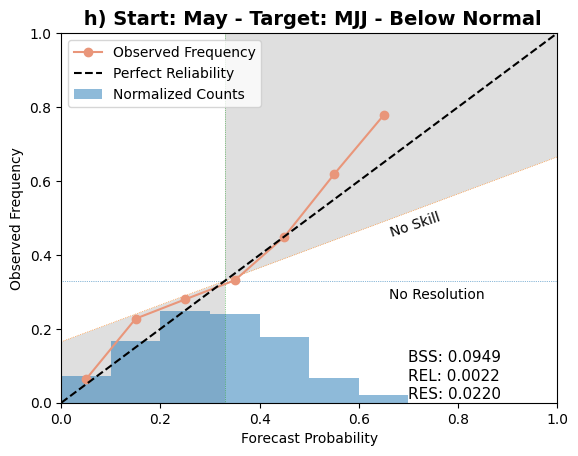

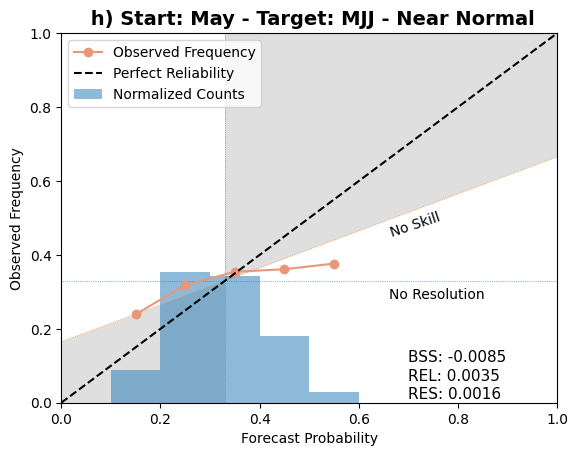

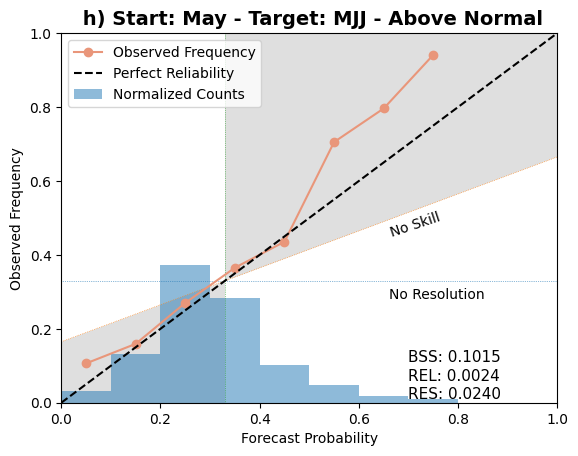

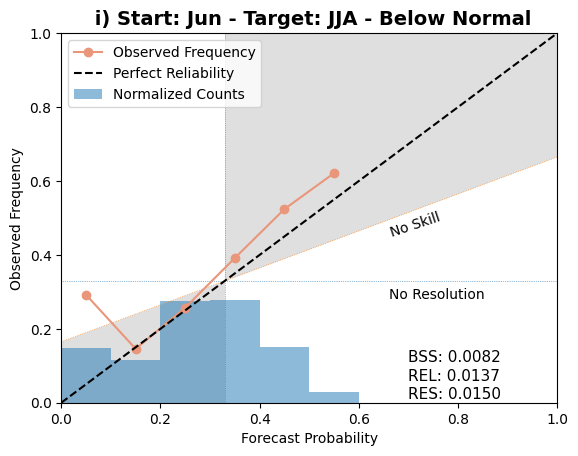

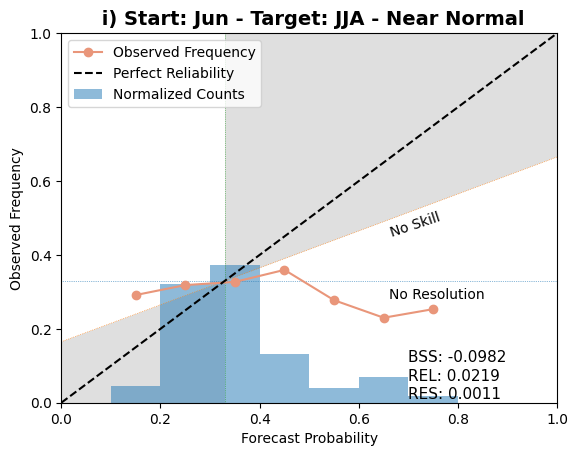

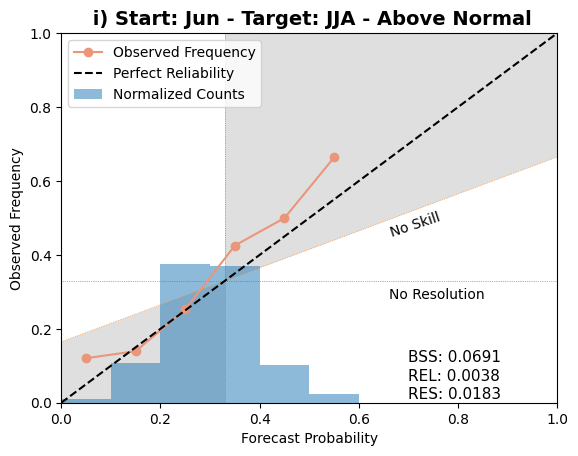

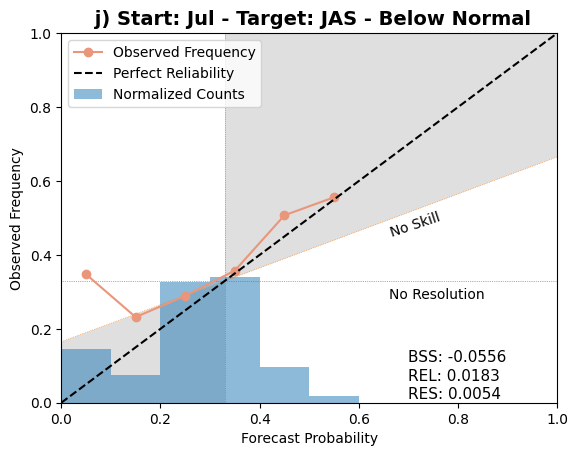

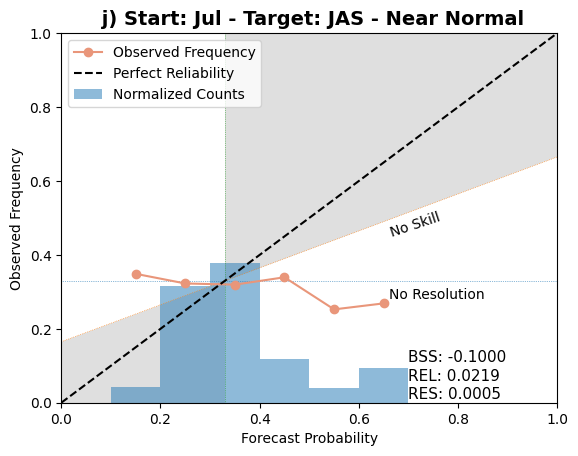

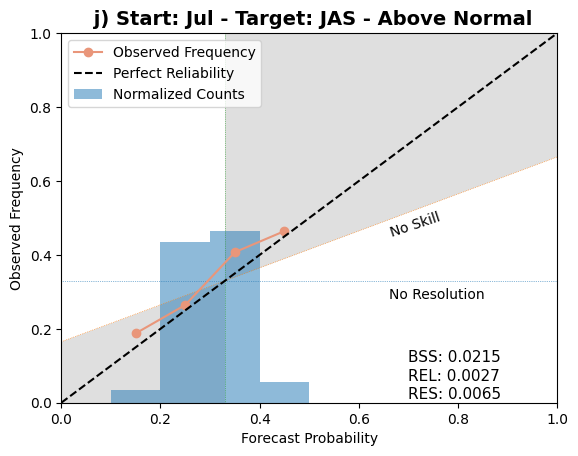

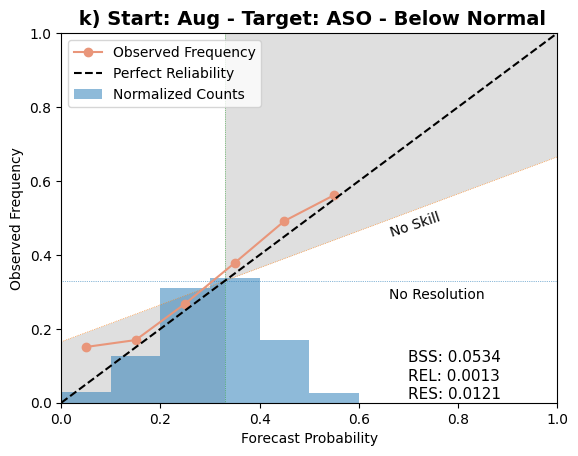

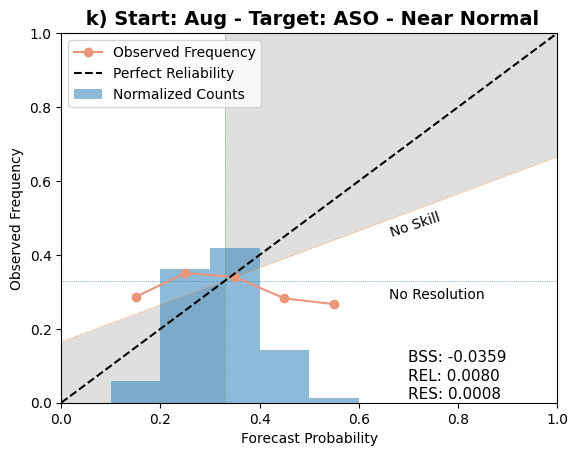

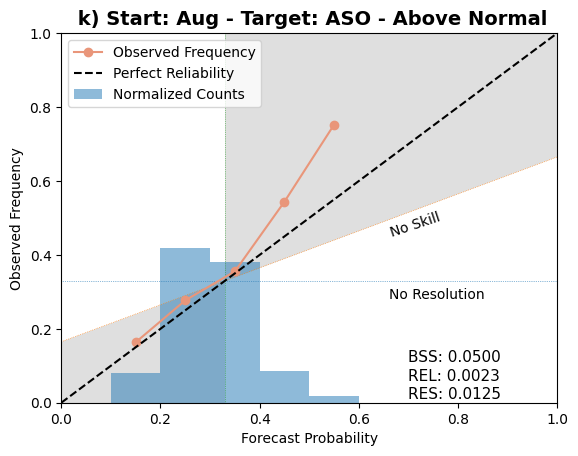

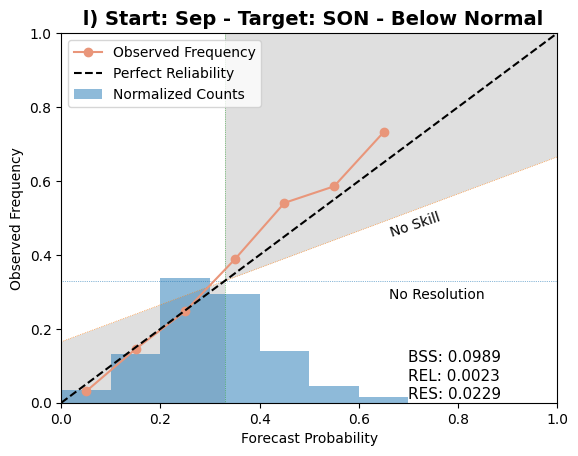

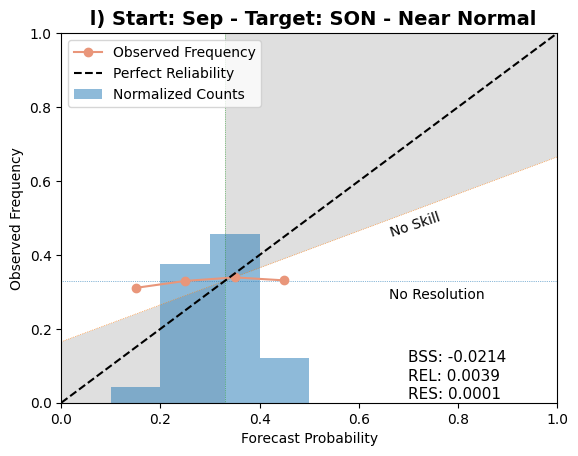

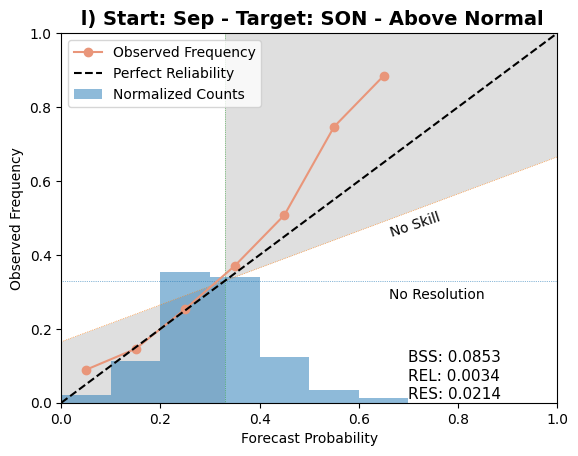

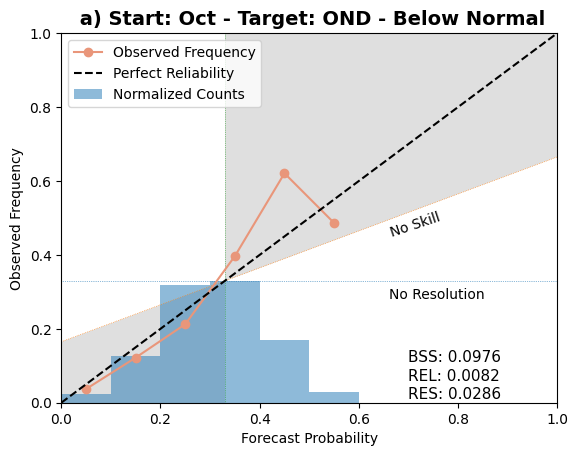

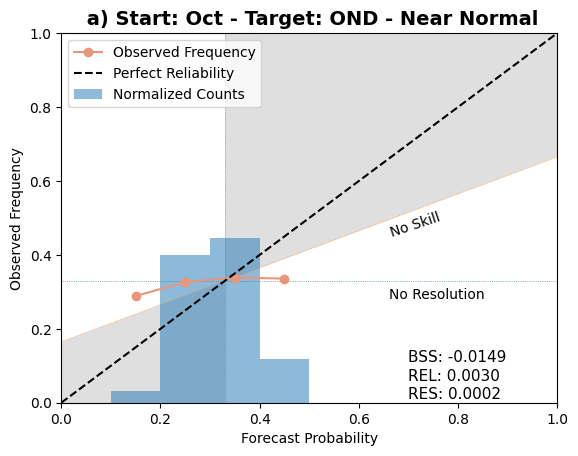

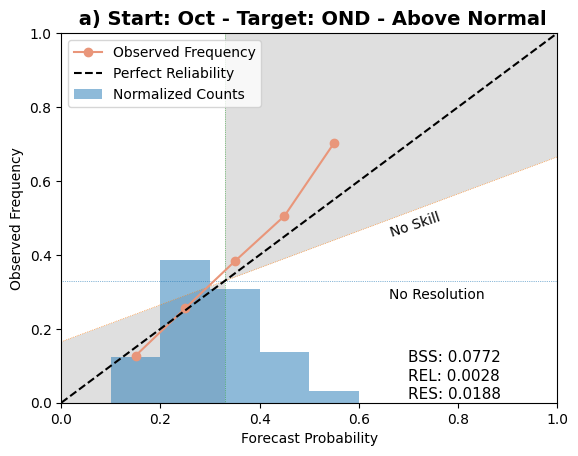

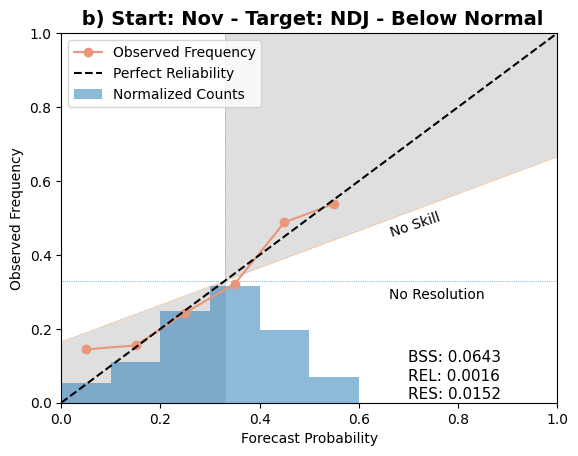

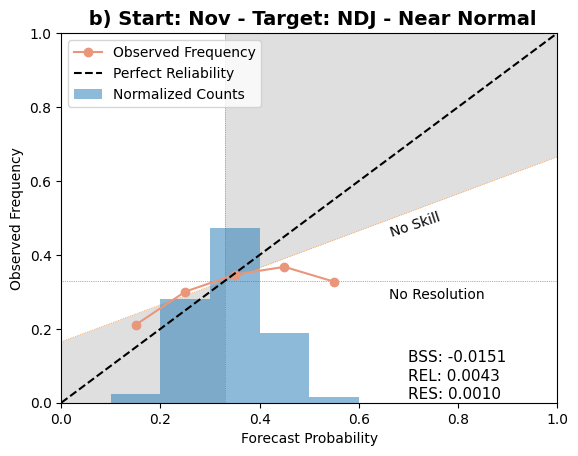

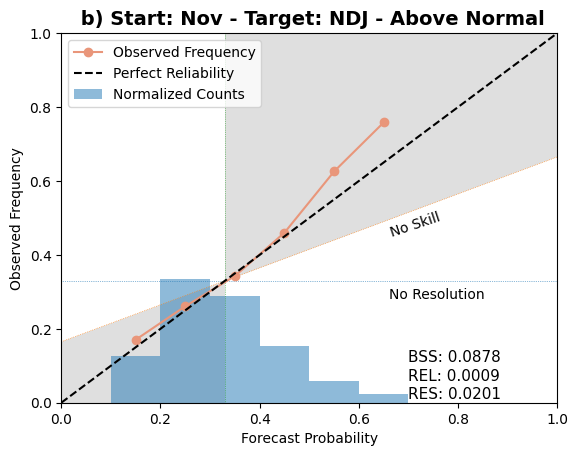

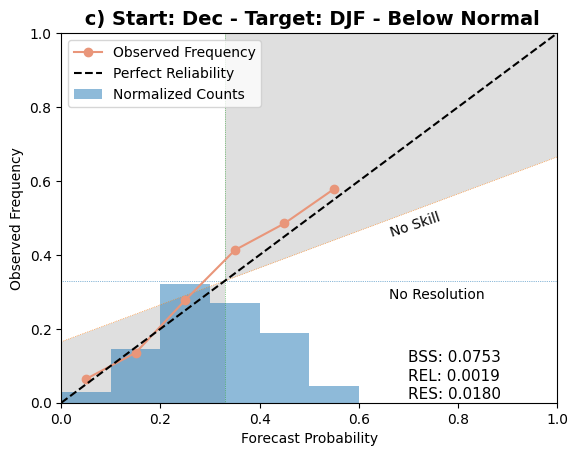

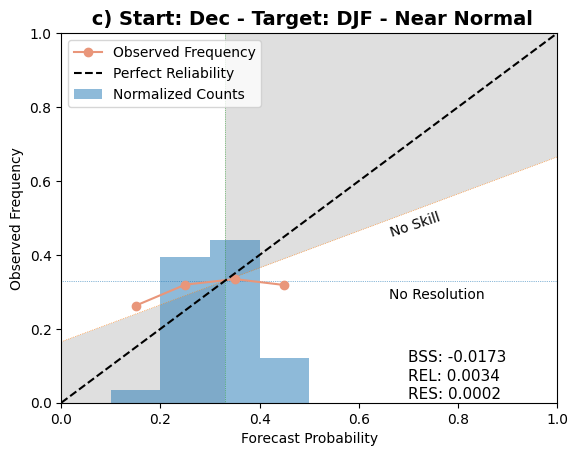

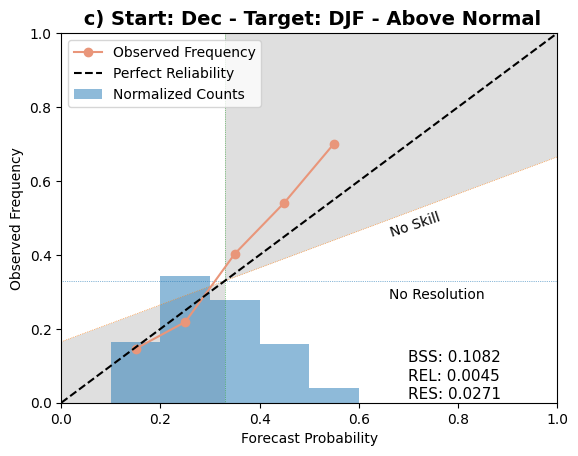

In [51]:
month_to_season = {1: "NDJ", 2: "DJF", 3: "JFM", 4: "FMA", 5: "MAM", 6: "AMJ",
                       7: "MJJ", 8: "JJA", 9: "JAS", 10: "ASO", 11: "SON", 12: "OND"}
    
season_to_label = {"OND": "a)", "NDJ": "b)", "DJF": "c)", "JFM": "d)", "FMA": "e)", "MAM": "f)",
                       "AMJ": "g)", "MJJ": "h)", "JJA": "i)", "JAS": "j)", "ASO": "k)", "SON": "l)"}


for start_month in range(1, 13):
    for lead_time in [2.5]:  # Only L=2.5
        for category in range(3):
            target_num = start_month + (lead_time-0.5)  # Adjust for 0.5-based indexing
            if target_num > 12:
                target_num -= 12

            category_string = {0: "Below Normal", 1: "Near Normal", 2: "Above Normal"}[category]
            start_month_name = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}[start_month]
            target_season_name = month_to_season[target_num]
            # letter for subplot
            letter = season_to_label[target_season_name]
            save_string = f"start{start_month_name}_target{target_season_name}_L{lead_time}_cat{category_string.replace(' ', '')}"


            reliability_diagram(
                ypred=forecast_final_precip.sel(L=lead_time, Smonth=start_month, category=category).values,
                t=ohe_obs_final_precip.sel(L=lead_time, Smonth=start_month, category=category).values,
                save_name=save_string,
                title = f" {letter} Start: {start_month_name} - Target: {target_season_name} - {category_string}")

# RPSS SPI

In [11]:
# compute month-specific quantiles (per gridpoint)
q33 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.33, dim='T')
q67 = spi_obs.sel(T=slice('1991-01-01', '2020-12-31')).groupby('T.month').quantile(0.67, dim='T')

# classify directly with groupby.map
def classify_month(da, q33=q33, q67=q67):
    m = int(da['T.month'][0])  # current month
    low = q33.sel(month=m)
    high = q67.sel(month=m)

    out = xr.full_like(da, np.nan, dtype=int)
    out = xr.where(da <= low, 0, out)
    out = xr.where((da > low) & (da < high), 1, out)
    out = xr.where(da >= high, 2, out)
    return out

spi_cat = spi_obs.groupby('T.month').map(classify_month)

# keep NaN where original was NaN
spi_cat = spi_cat.where(~np.isnan(spi_obs))

In [ ]:
from scipy.stats import pearson3, norm
def compute_spi_pearson3(da, dim='S'):
    """
    Compute SPI (Standardized Precipitation Index) using Pearson Type III distribution
    along the specified time dimension.
    """
    def _spi_1d(x):
        x = np.asarray(x, dtype=float)
        mask = np.isfinite(x)

        if mask.sum() < 3 or np.all(x[mask] <= 0):
            return np.full_like(x, np.nan, dtype=float)

        try:
            skew, loc, scale = pearson3.fit(x[mask])
            cdf = pearson3.cdf(x[mask], skew, loc=loc, scale=scale)
            spi_vals = norm.ppf(cdf)
            out = np.full_like(x, np.nan, dtype=float)
            out[mask] = spi_vals
            return out
        except Exception:
            return np.full_like(x, np.nan, dtype=float)

    # Apply along time dimension
    spi = xr.apply_ufunc(
        _spi_1d,
        da,
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],   # preserve time dim
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
    )

    return spi

In [19]:
def compute_rpss_subset(obs, fcst):
    n_cat = 3
    ref_probs = np.ones(n_cat) / n_cat

    rpss_list = []
    ohe_obs_list = []
    forecast_probs_list = []
    
    # L=2.5 corresponds to index 2
    TARGET_LEAD_INDEX = 2 

    for s_month in range(1, 13):  # start months
        print(f"Processing start month {s_month}")
        
        # Only iterate for the target lead time index (index 2 for L=2.5)
        for lead_time in [TARGET_LEAD_INDEX]:
            print(f"   Lead time index {lead_time}")

            # Forecasts for given start month and lead, sum over 3-month window
            # This requires L=lead_time, L=lead_time-1, L=lead_time-2 to be present in fcst
            fcst_sel = (
                fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time)
                + fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time - 1)
                + fcst.sel(S=fcst['S.month'] == s_month).isel(L=lead_time - 2)
            )

            # --- Compute SPI using Pearson Type III for each ensemble member ---

            # Assuming compute_spi_pearson3 is available
            spi_fcst = compute_spi_pearson3(fcst_sel, dim='S')

            t_month = (s_month + lead_time) % 12 or 12

            # Convert S→T
            S_values = fcst_sel['S'].values
            T_values = [pd.Timestamp(s) + pd.DateOffset(months=lead_time) for s in S_values]
            spi_fcst = spi_fcst.assign_coords(S=T_values).rename({'S': 'T'})

            # --- Compute tercile thresholds from SPI forecasts ---
            q33 = spi_fcst.quantile(0.33, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q67 = spi_fcst.quantile(0.67, dim=["M", "T"], skipna=True).drop_vars("quantile", errors="ignore")
            q33_b = q33.broadcast_like(spi_fcst)
            q67_b = q67.broadcast_like(spi_fcst)

            # Boolean masks
            mask_below = spi_fcst < q33_b
            mask_near  = (spi_fcst >= q33_b) & (spi_fcst <= q67_b)
            mask_above = spi_fcst > q67_b

            # Ensemble probabilities
            below = mask_below.mean(dim="M", skipna=True)
            near  = mask_near.mean(dim="M", skipna=True)
            above = mask_above.mean(dim="M", skipna=True)

            prob = xr.concat([below, near, above], dim="category").assign_coords(category=[0, 1, 2])

            # Matching obs
            obs_month = obs.sel(T=prob['T'])
            prob = prob.where(obs_month.notnull(), drop=False).transpose('T', 'Y', 'X', 'category').sortby('T')
            prob = prob.where(mask==0)

            # Reference probabilities
            ref_probs_da = xr.DataArray(ref_probs, dims=["category"])
            ref_probs_broadcast = ref_probs_da.broadcast_like(prob)

            # One-hot encode obs
            ohe_obs = xr.concat([
                (obs_month == 0).assign_coords(category=0),
                (obs_month == 1).assign_coords(category=1),
                (obs_month == 2).assign_coords(category=2),
            ], dim='category').where(obs_month.notnull()).transpose('T', 'Y', 'X', 'category').sortby('T')

            # RPS & RPSS
            rps_vals = xs.rps(ohe_obs, prob, dim="T", category_edges=None, input_distributions="p")
            ref_rps_vals = xs.rps(ohe_obs, ref_probs_broadcast, dim="T", category_edges=None, input_distributions="p")
            rpss = 1 - (rps_vals / ref_rps_vals)

            # Store the result, using the actual lead time value (2.5) for the coordinate
            rpss_value = fcst['L'].isel(L=lead_time).item()

            rpss_list.append(rpss.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))
            ohe_obs_list.append(ohe_obs.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))
            forecast_probs_list.append(prob.expand_dims({"L": [rpss_value], "Smonth": [s_month]}))


    rpss_final = xr.combine_by_coords(rpss_list)
    ohe_obs_final = xr.concat(ohe_obs_list, dim="T").sortby("T")
    forecast_probs_final = xr.concat(forecast_probs_list, dim="T").sortby("T")
    return rpss_final, ohe_obs_final, forecast_probs_final



# --- Call the function with spatial subsetting and the necessary lead times (0.5, 1.5, 2.5) ---
rpss_final_spi, ohe_obs_final_spi, forecast_probs_final_spi = compute_rpss_subset(
    obs=spi_cat,
    fcst=combined_nmme.prec.sel(
        S=slice('1991-01-01', '2020-12-31'),
        L=slice(0.5, 2.5), # Must include 0.5, 1.5, and 2.5 for the 3-month sum
    )
)

Processing start month 1
   Lead time index 2
Processing start month 2
   Lead time index 2
Processing start month 3
   Lead time index 2
Processing start month 4
   Lead time index 2
Processing start month 5
   Lead time index 2
Processing start month 6
   Lead time index 2
Processing start month 7
   Lead time index 2
Processing start month 8
   Lead time index 2
Processing start month 9
   Lead time index 2
Processing start month 10
   Lead time index 2
Processing start month 11
   Lead time index 2
Processing start month 12
   Lead time index 2


In [20]:
rpss_final_spi.to_netcdf('data/rpss_spi_hindcast.nc')
ohe_obs_final_spi.to_netcdf('data/ohe_obs_spi_hindcast.nc')
forecast_probs_final_spi.to_netcdf('data/forecast_probs_spi_hindcast.nc')

In [4]:
rpss_final_spi = xr.load_dataset('data/rpss_spi_hindcast.nc').rename({'__xarray_dataarray_variable__':'rpss'}).rpss
ohe_obs_final_spi = xr.load_dataset('data/ohe_obs_spi_hindcast.nc').spi
forecast_probs_final_spi = xr.load_dataset('data/forecast_probs_spi_hindcast.nc').prec

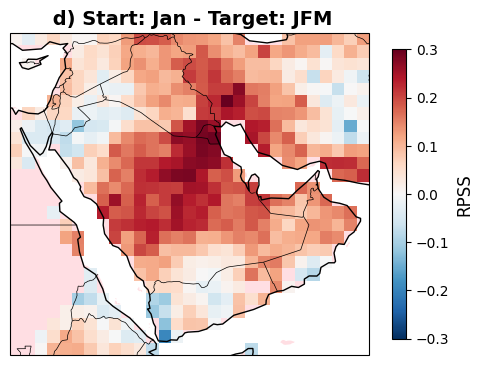

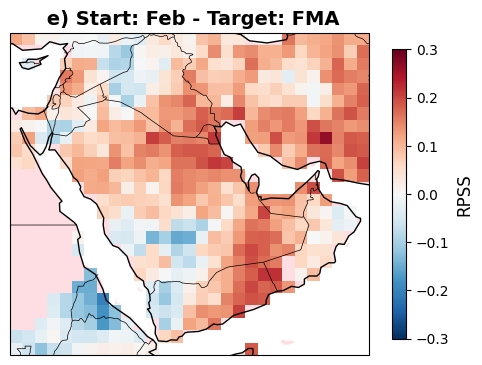

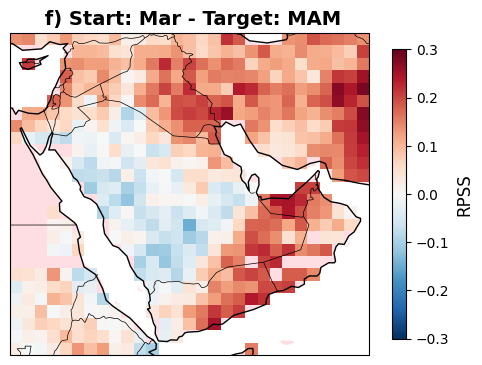

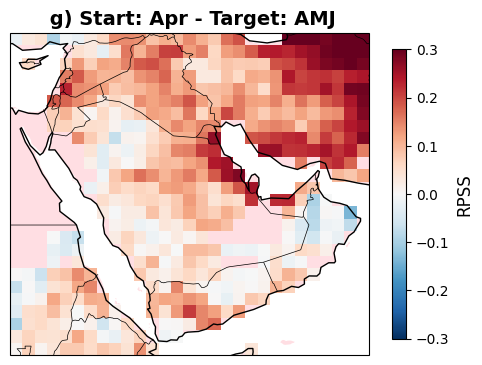

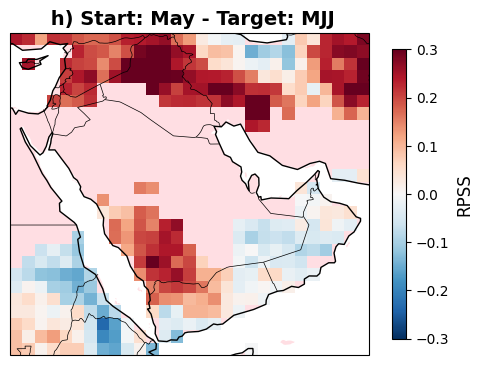

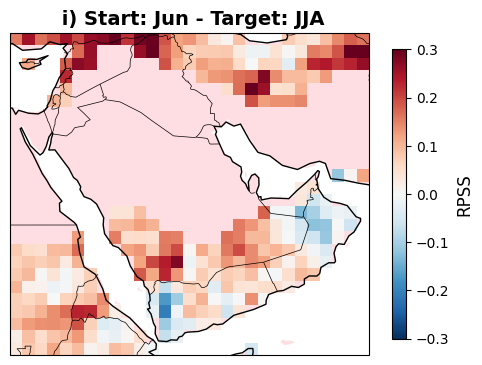

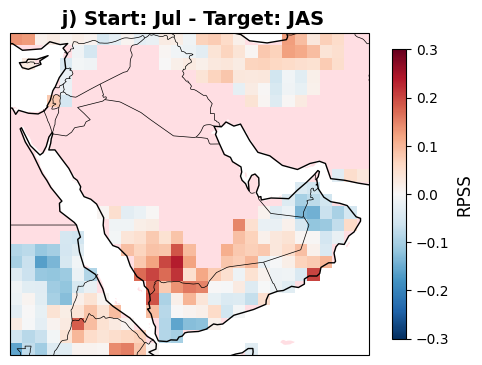

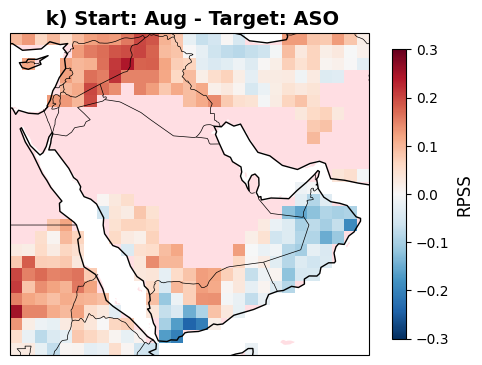

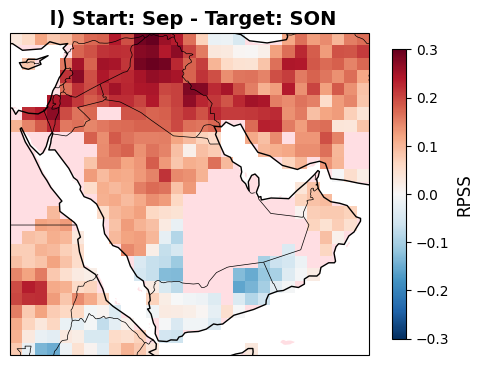

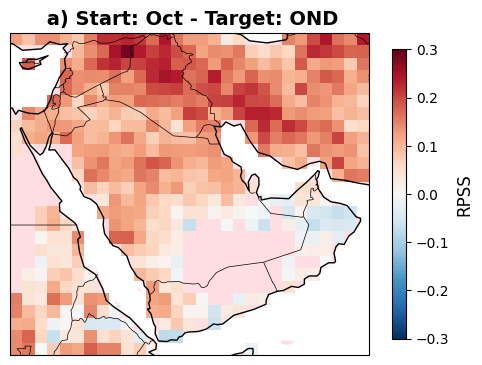

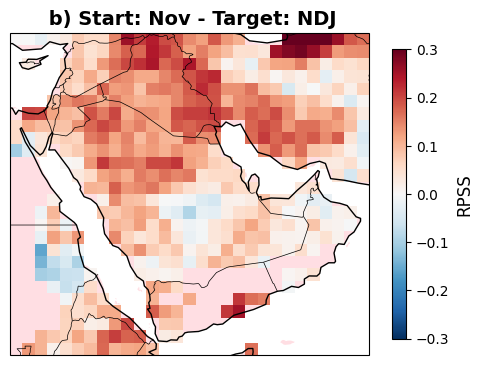

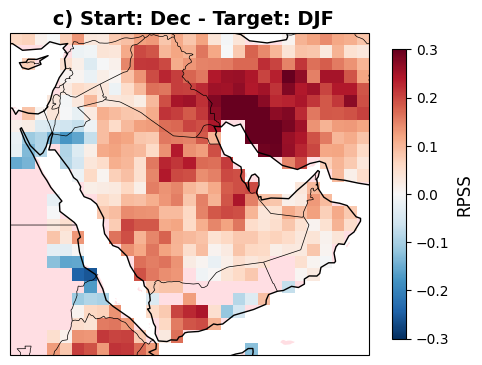

In [25]:

L = 2
for month in range(1, 13):
    seasons_to_month = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                        7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}

    start = seasons_to_month[month]
    target_num = month + L 
    if target_num > 12:
        target_num -= 12

    month_to_season = {1: "NDJ", 2: "DJF", 3: "JFM", 4: "FMA", 5: "MAM", 6: "AMJ",
                       7: "MJJ", 8: "JJA", 9: "JAS", 10: "ASO", 11: "SON", 12: "OND"}
    
    season_to_label = {"OND": "a)", "NDJ": "b)", "DJF": "c)", "JFM": "d)", "FMA": "e)", "MAM": "f)",
                       "AMJ": "g)", "MJJ": "h)", "JJA": "i)", "JAS": "j)", "ASO": "k)", "SON": "l)"}
    
    target = month_to_season[target_num]
    
    label = season_to_label[target]
    
    title_str = f" {label} Start: {start} - Target: {target}"
    L2 = L + 0.5

    rpss_final_sel = rpss_final_spi.sel(Smonth=month, L=L2)
    fig, ax = plt.subplots(
            figsize=(5, 4),
            subplot_kw={"projection": ccrs.PlateCarree()}
        )

    im = rpss_final_sel.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.3, vmax=0.3,
            add_colorbar=False
        )

    
    # add coastlines, borders, land
    ax.coastlines(resolution="110m", linewidth=1)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor="lightpink", alpha=0.45)

    # titles
    plt.title(f"{title_str}", fontsize=14, fontweight='bold')

    # colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", shrink=0.8)
    cbar.set_label("RPSS", fontsize=12)

    plt.tight_layout()
    plt.show()
        # save
    fig.savefig(
        f"figures/rpss/spi/start{start}_target{target}.pdf",
        dpi=150, bbox_inches="tight"
    )



# Reliability Diagram

In [5]:
os.makedirs('figures/reliability/spi', exist_ok=True)

In [6]:
from matplotlib.patches import Patch, Polygon
from operator import sub
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.io.shapereader


def compute_reliability_score(y_true, y_pred, num_bins=10):
    """
    Compute the reliability score for probabilistic forecasts.

    Parameters:
    y_true (numpy array): Array of true binary outcomes (0 or 1).
    y_pred (numpy array): Array of predicted probabilities (between 0 and 1).
    num_bins (int): Number of bins to use for grouping predicted probabilities.

    Returns:
    float: The reliability score.
    """
    
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    # Initialize arrays to hold the average predicted probabilities and observed frequencies for each bin
    bin_avg_pred = np.zeros(num_bins)
    bin_avg_true = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)
    
    # Bin edges
    bin_edges = np.linspace(0, 1, num_bins + 1)
    
    # Assign each prediction to a bin
    bin_indices = np.digitize(y_pred, bin_edges, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are within valid range
    
    # Calculate bin statistics
    for i in range(num_bins):
        # Indices of predictions in the current bin
        bin_mask = (bin_indices == i)
        bin_count = np.sum(bin_mask)
        
        if bin_count > 0:
            # Average predicted probability for the current bin
            bin_avg_pred[i] = np.mean(y_pred[bin_mask])
            # Observed frequency (empirical probability) for the current bin
            bin_avg_true[i] = np.mean(y_true[bin_mask])
            bin_counts[i] = bin_count
    
    # Calculate the reliability score
    reliability_score = np.nansum((bin_avg_pred - bin_avg_true)**2 * bin_counts) / np.sum(bin_counts)
    
    return reliability_score

def compute_brier_skill_score(y_pred, t):
    """
    Compute the Brier Skill Score (BSS) for probabilistic forecasts.

    Parameters:
    y_pred (numpy array): Predicted probabilities.
    t (numpy array): True binary outcomes (0 or 1).

    Returns:
    float: The Brier Skill Score (BSS).
    """
    # Adjust y_pred to avoid edge cases
    y_pred = y_pred * 0.9999999999999
    
    # Mask to remove NaNs
    msk = np.where(~np.isnan(y_pred + t))
    y_pred = y_pred[msk]
    t = t[msk]
    
    # Calculate the base rate (climatological mean)
    base_rate = np.nanmean(t)
    base_rate = np.ones_like(np.nanmean(t)) * 1/3
    
    # Calculate the Brier Score (BS)
    bs = np.nanmean((y_pred - t)**2)
    
    # Calculate the Brier Score for the reference forecast (BR)
    br = np.nanmean((base_rate - t)**2)
    
    # Calculate the Brier Skill Score (BSS)
    bss = 1 - (bs / br)
    
    return bss

def compute_resolution_score(predictions, observations, num_bins=10):
    """
    Compute the resolution score for probabilistic forecasts.

    Parameters:
    predictions (numpy array): Predicted probabilities.
    observations (numpy array): True binary outcomes (0 or 1).
    num_bins (int): Number of bins to use for grouping predicted probabilities.

    Returns:
    float: The resolution score.
    """
    # Adjust predictions to avoid edge cases
    predictions = predictions * 0.9999999999999
    
    # Mask to remove NaNs
    mask = np.where(~np.isnan(predictions + observations))
    predictions = predictions[mask]
    observations = observations[mask]
    
    # Calculate the base rate (climatological mean)
    base_rate = np.nanmean(observations)
    
    # Initialize arrays to hold the average observed frequencies and counts for each bin
    bin_obs_freq = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)
    
    # Bin edges
    bin_edges = np.linspace(0, 1, num_bins + 1)
    
    # Assign each prediction to a bin
    bin_indices = np.digitize(predictions, bin_edges, right=True) - 1
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)  # Ensure indices are within valid range
    
    # Calculate bin statistics
    for i in range(num_bins):
        bin_mask = (bin_indices == i)
        bin_counts[i] = bin_mask.sum()
        
        if bin_counts[i] > 0:
            bin_obs_freq[i] = observations[bin_mask].mean()
    
    # Calculate the resolution score
    resolution = np.nansum(bin_counts * (bin_obs_freq - base_rate)**2) / np.sum(bin_counts)
    
    return resolution

def reliability_diagram(ypred, t, title=None, perfect_reliability_line=True, plot_hist=True, fig=None, ax=None, bin_minimum_pct=0.01, tercile_skill_area=True, scores=True,
                        save_name=None):
    """
    Compute and plot a reliability diagram (calibration curve) with a normalized histogram of the forecast probabilities.

    Parameters:
    ypred (numpy array): Predicted probabilities.
    t (numpy array): True binary outcomes (0 or 1).
    title (str): Title for the plot.
    perfect_reliability_line (bool): Whether to plot the perfect reliability line.
    plot_hist (bool): Whether to plot the histogram of forecast probabilities.
    fig (matplotlib Figure): Figure object to plot on.
    ax (matplotlib Axes): Axes object to plot on.
    bin_minimum_pct (float): Minimum percentage of samples in a bin to include it in the plot.
    """


    ypred = ypred * 0.9999999999999  # Avoids edge cases with digitize
    assert ypred.shape == t.shape, 'Inconsistent shapes between ypred and t - {} vs {}'.format(ypred.shape, t.shape)

    # Mask to remove NaNs
    msk = np.where(~np.isnan(ypred + t))
    ypred = ypred[msk]
    t = t[msk]

    # Total number of non-NaN samples
    countnonnan = np.ones_like(ypred).sum()

    # Initialize arrays
    bin_avg_pred = np.zeros(10)
    bin_obs_freq = np.zeros(10)
    bin_counts = np.zeros(10)

    # Iterate over bins
    for i in range(10):
        bin_mask = (ypred >= i / 10.0) & (ypred < (i / 10.0 + 0.1))
        bin_counts[i] = bin_mask.sum()
        
        if bin_counts[i] > 0:
            bin_avg_pred[i] = ypred[bin_mask].mean()
            bin_obs_freq[i] = t[bin_mask].mean()

    # Compute bin centers
    bin_centers = (np.arange(10) + 0.5) / 10.0

    # Mask bins with insufficient data
    valid_bins = bin_counts / countnonnan >= bin_minimum_pct
    bin_centers = bin_centers[valid_bins]
    bin_avg_pred = bin_avg_pred[valid_bins]
    bin_obs_freq = bin_obs_freq[valid_bins]
    bin_counts = bin_counts[valid_bins]

    # Normalize bin counts for the histogram
    bin_counts = bin_counts / countnonnan

    if ax is None:
        fig, ax = plt.subplots()

    b1, t1 = ax.set_ylim(0, 1)
    l, r = ax.set_xlim(0, 1)

    #plt.hist(epoelm_xval[:, 0], bins=11)
    if tercile_skill_area:
        ur = Polygon([[0.33, 0.33 ], [0.33, 1], [1,1], [1, 1.33/2.0]], facecolor='gray', alpha=0.25)
        bl = Polygon([[0.33, 0.33 ], [0.33, 0], [0,0], [0, 0.33/2.0]], facecolor='gray', alpha=0.25)
        ax.add_patch(ur)
        ax.add_patch(bl)

        ax.text(0.66, 0.28, 'No Resolution')
        noresolution = ax.plot([0, 1], [0.33,0.33], lw=0.5, linestyle='dotted')

        noskill = ax.plot([0, 1], [0.33/2.0,1.33/2.0], lw=0.5, linestyle='dotted')
        figW, figH = ax.get_figure().get_size_inches()
        _, _, w, h = ax.get_position().bounds
        disp_ratio = (figH * h) / (figW * w)
        data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())
        angle = (180.0/np.pi)*np.arctan(disp_ratio / data_ratio)
        ax.text(0.66, 0.45, 'No Skill', rotation=angle*0.5)

        ax.plot([0.33, 0.33], [0,1], lw=0.5, linestyle='dotted')

    # Plot the reliability diagram
    ax.plot(bin_centers, bin_obs_freq, marker='o', linestyle='-', color='darksalmon', label='Observed Frequency')

    # Plot the perfect reliability line
    if perfect_reliability_line:
        ax.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfect Reliability')

    # Plot normalized histogram
    if plot_hist:
        ax.bar(bin_centers, bin_counts, width=0.1, color='tab:blue', alpha=0.5, label='Normalized Counts')

    if scores:
        bss = compute_brier_skill_score(ypred, t)
        rel = compute_reliability_score(t, ypred)
        res = compute_resolution_score(ypred, t)
        ax.text( 0.7, 0.11, 'BSS: {:0.04f}'.format(bss), fontdict={'size': 11})
        ax.text( 0.7, 0.06, 'REL: {:0.04f}'.format(rel), fontdict={'size': 11})
        ax.text( 0.7, 0.01, 'RES: {:0.04f}'.format(res), fontdict={'size': 11})

    ax.set_xlabel('Forecast Probability')
    ax.set_ylabel('Observed Frequency')
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1])
    if title is not None:
        ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    if save_name is not None:
        plt.savefig(f'figures/reliability/spi/{save_name}.pdf', dpi=150, bbox_inches="tight")

    plt.show()

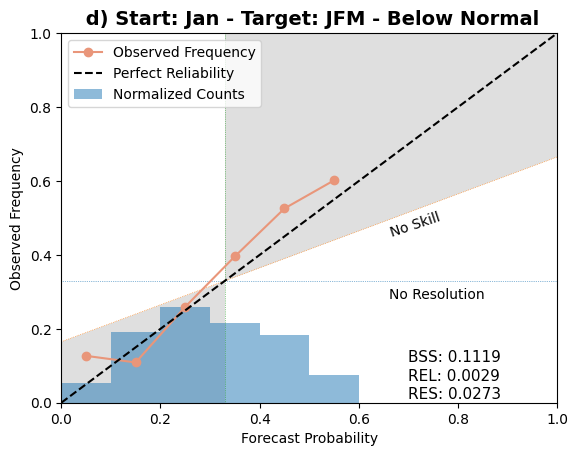

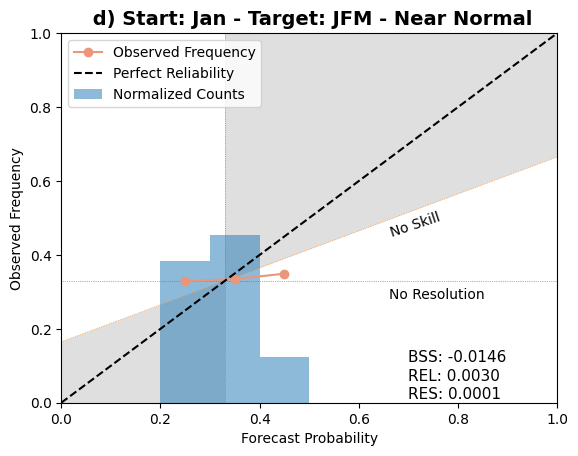

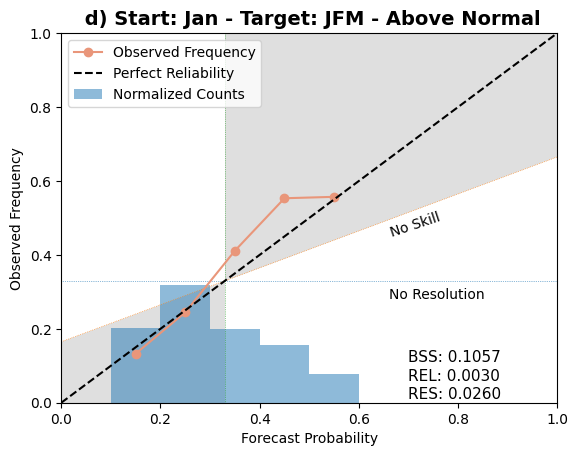

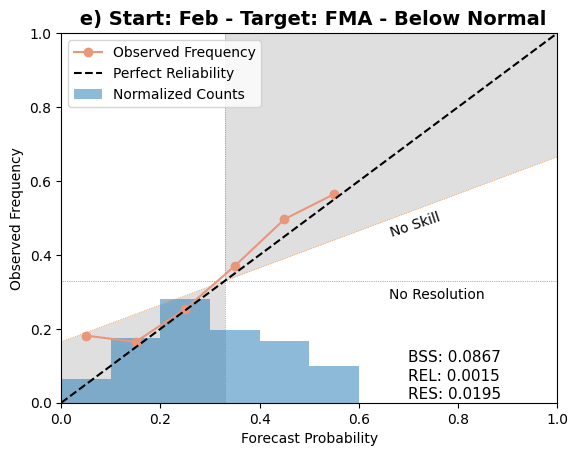

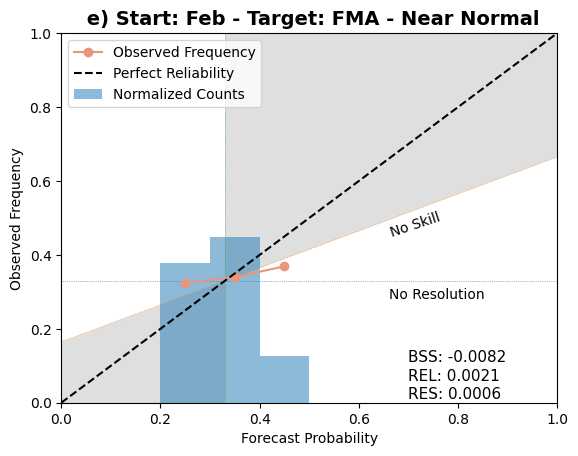

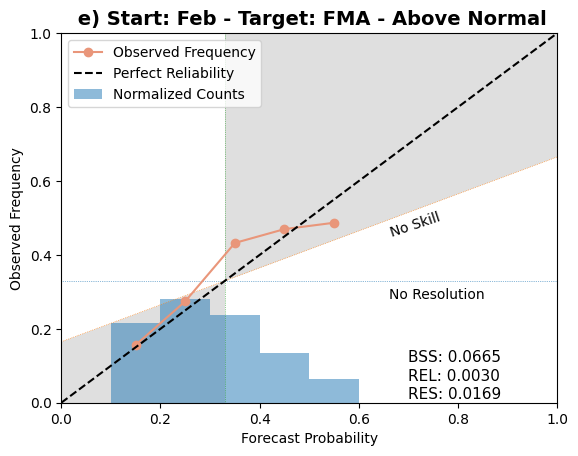

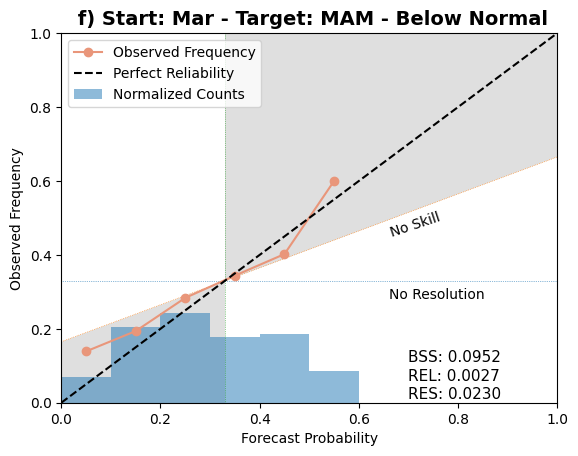

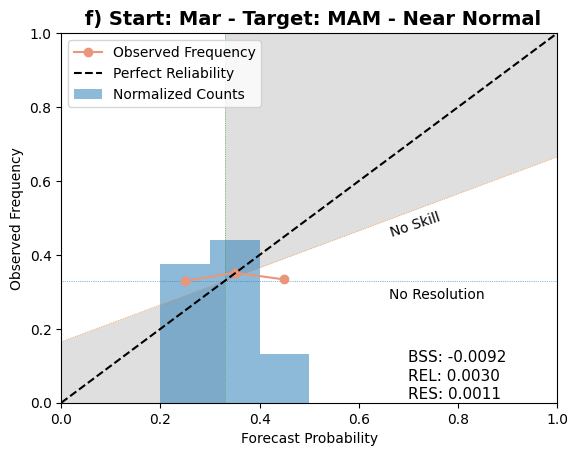

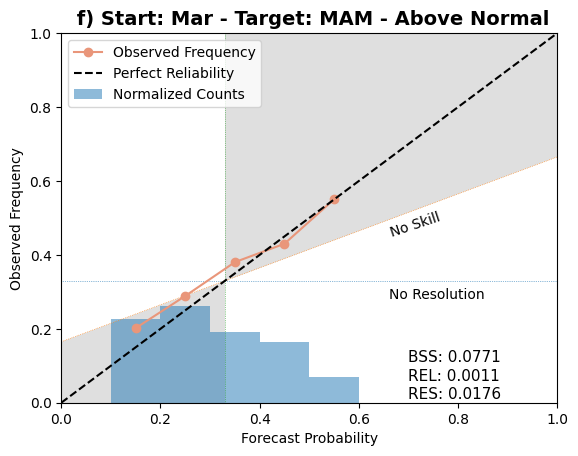

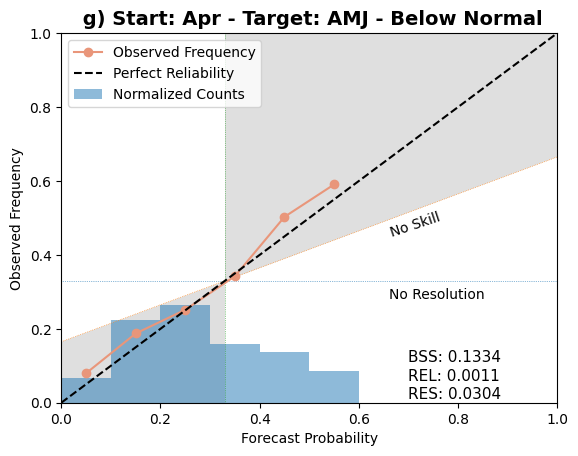

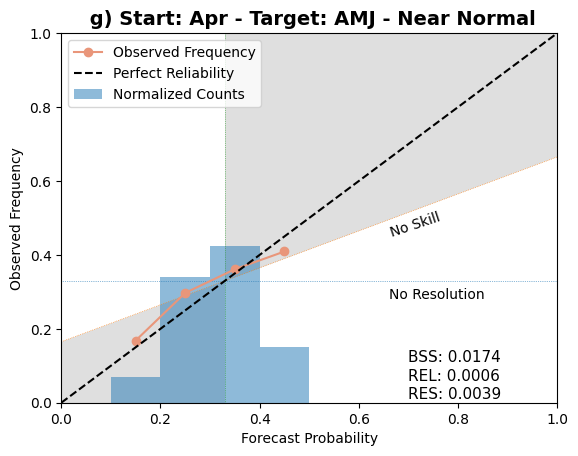

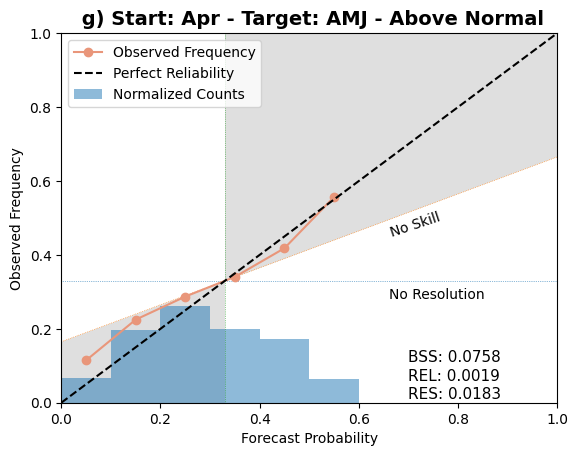

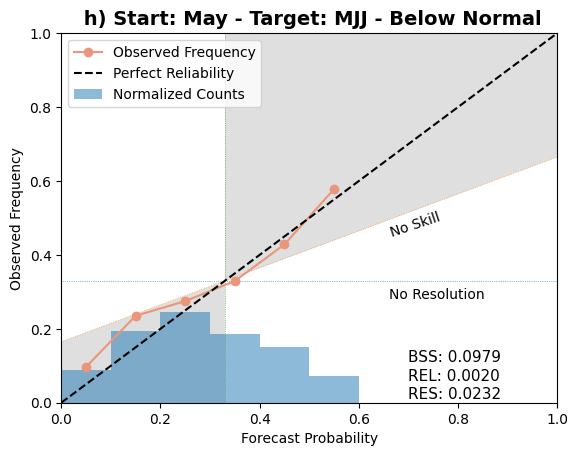

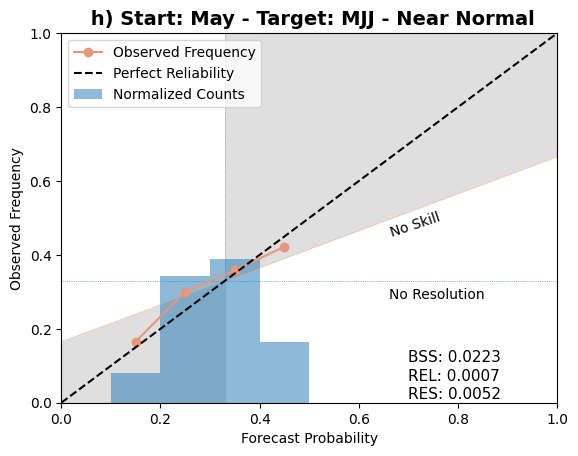

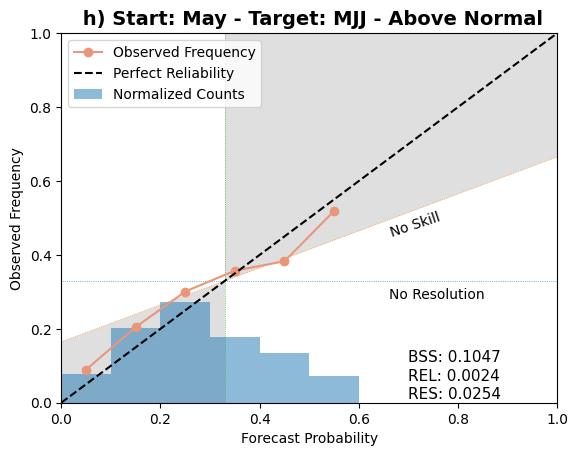

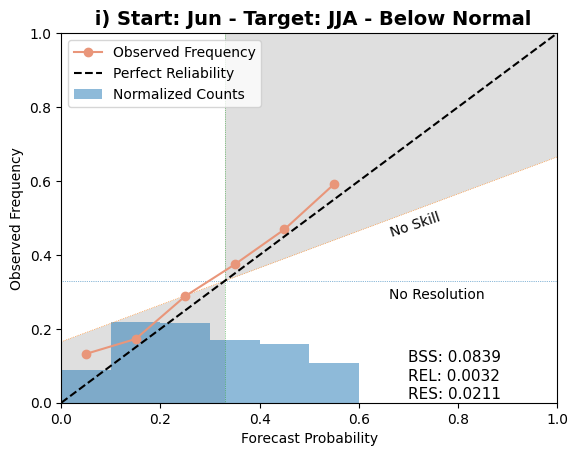

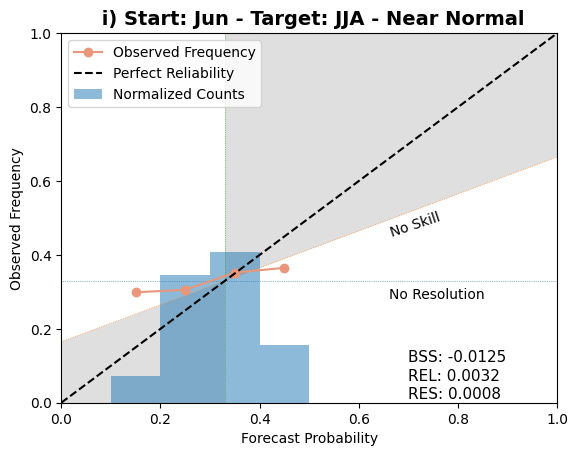

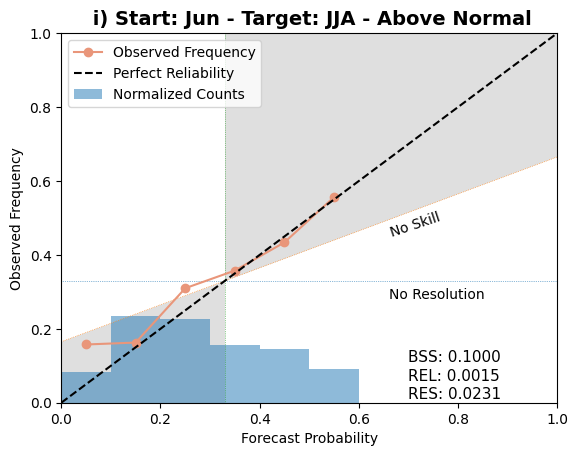

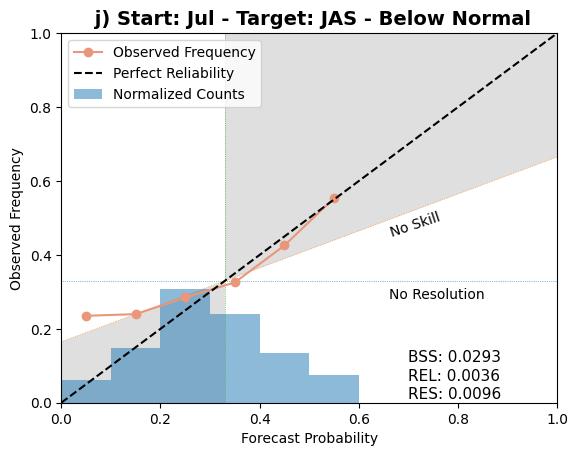

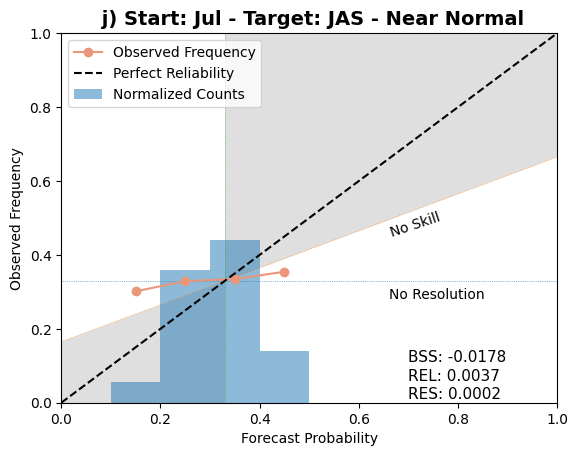

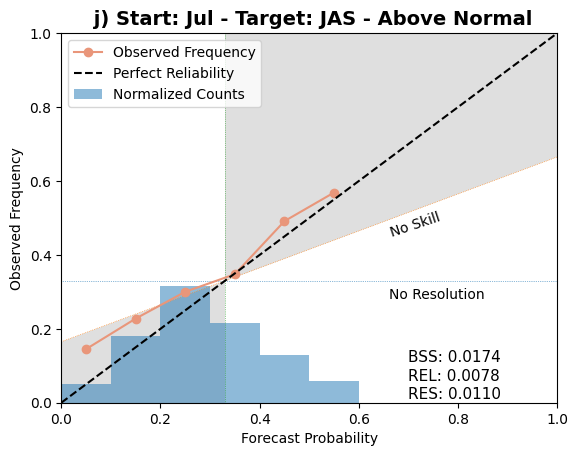

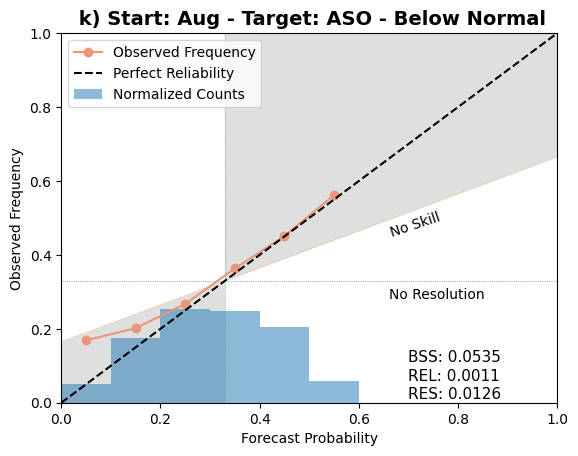

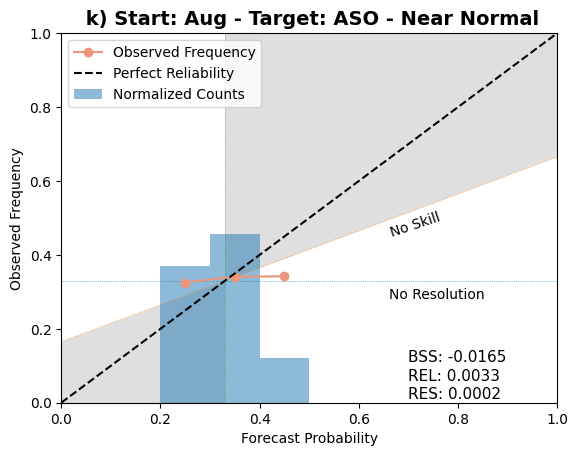

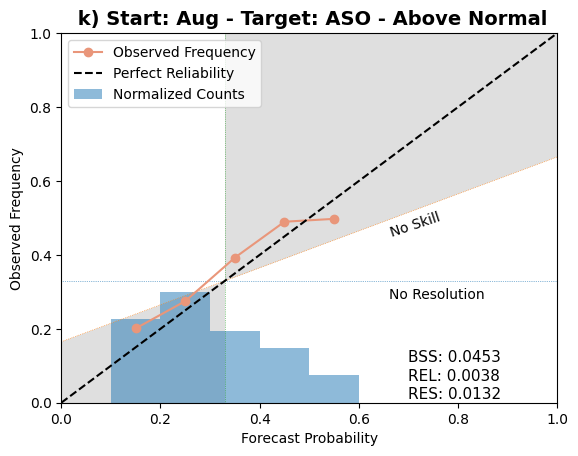

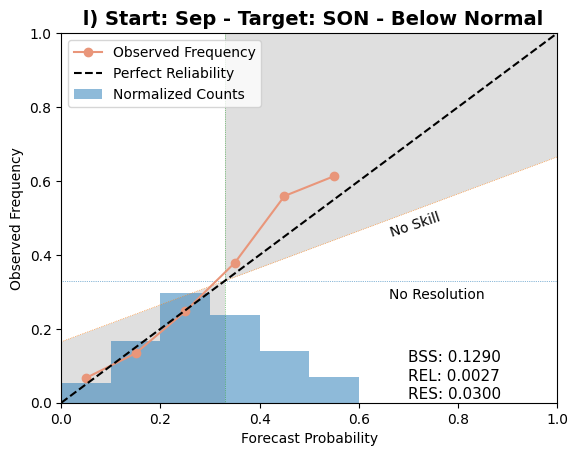

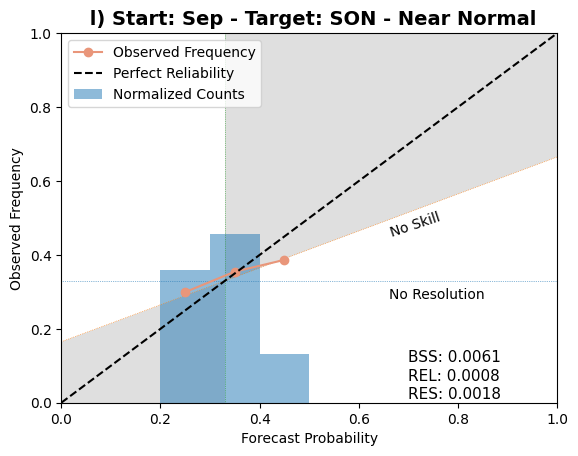

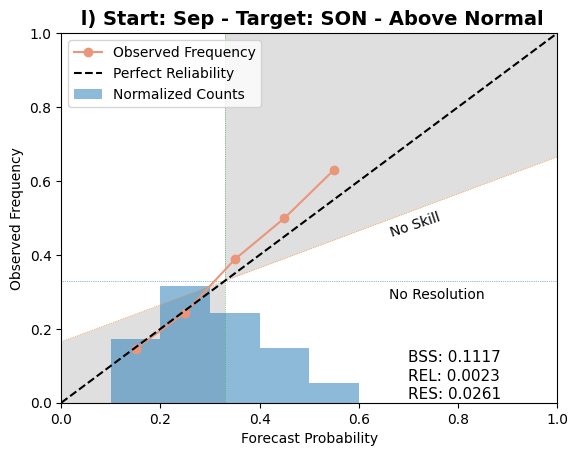

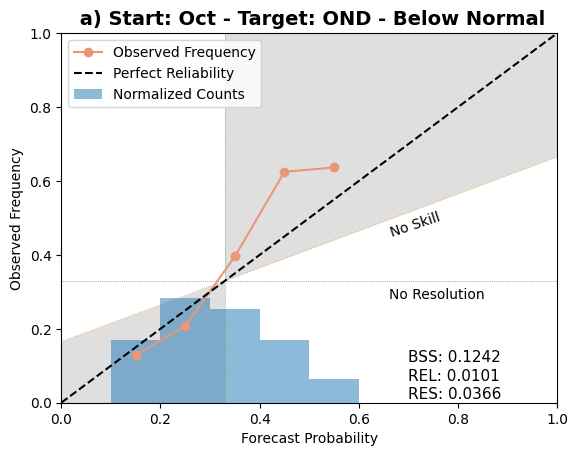

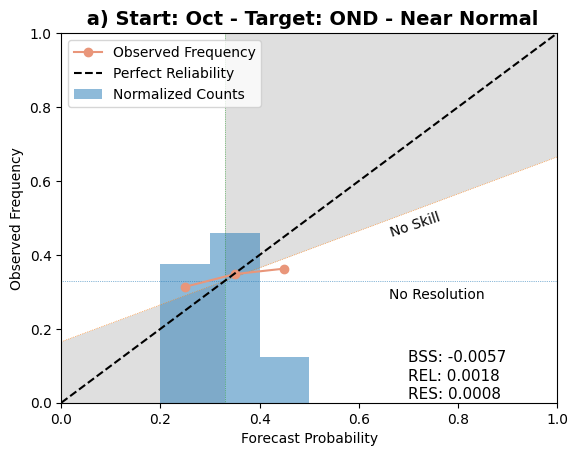

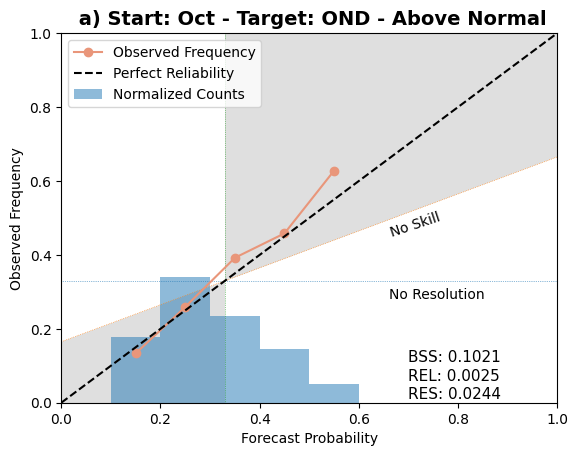

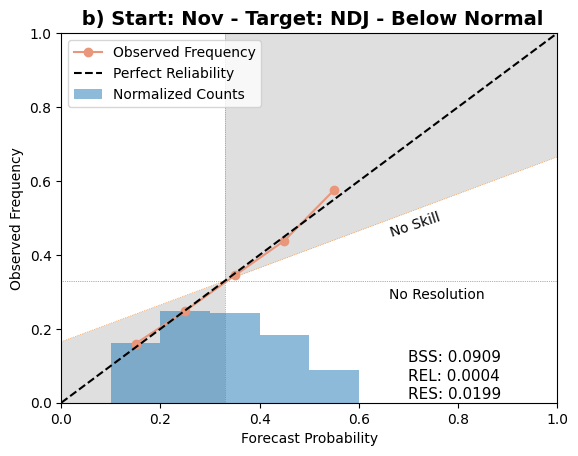

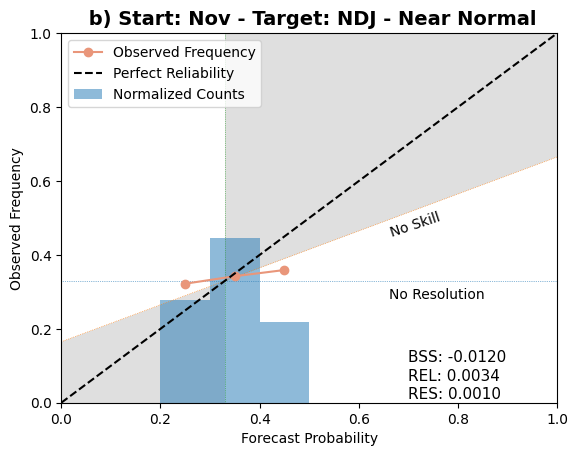

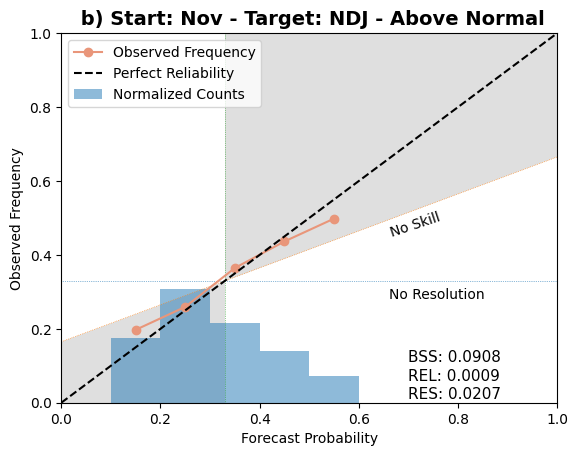

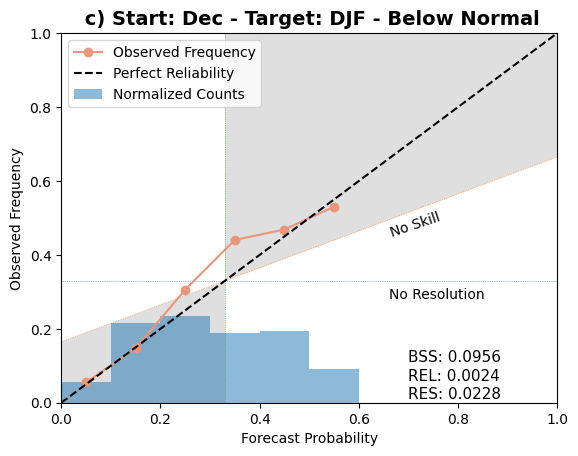

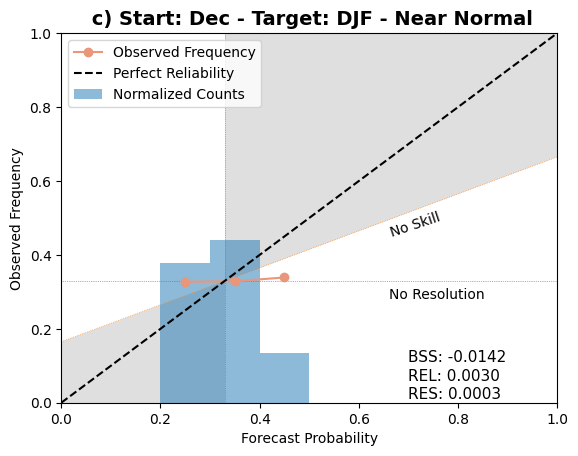

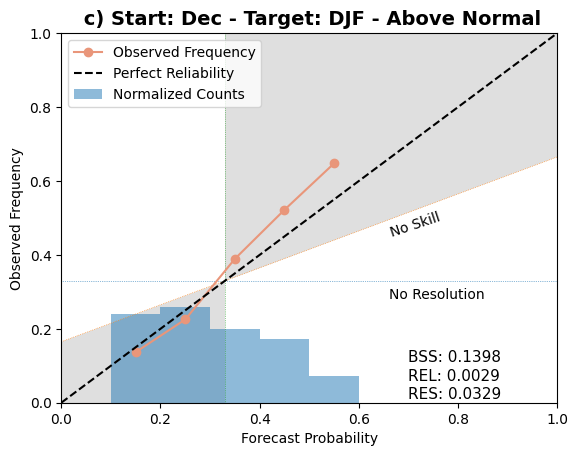

In [12]:
month_to_season = {1: "NDJ", 2: "DJF", 3: "JFM", 4: "FMA", 5: "MAM", 6: "AMJ",
                       7: "MJJ", 8: "JJA", 9: "JAS", 10: "ASO", 11: "SON", 12: "OND"}
    
season_to_label = {"OND": "a)", "NDJ": "b)", "DJF": "c)", "JFM": "d)", "FMA": "e)", "MAM": "f)",
                       "AMJ": "g)", "MJJ": "h)", "JJA": "i)", "JAS": "j)", "ASO": "k)", "SON": "l)"}


for start_month in range(1, 13):
    for lead_time in [2.5]:  # Only L=2.5
        for category in range(3):
            target_num = start_month + (lead_time-0.5)  # Adjust for 0.5-based indexing
            if target_num > 12:
                target_num -= 12

            category_string = {0: "Below Normal", 1: "Near Normal", 2: "Above Normal"}[category]
            start_month_name = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}[start_month]
            target_season_name = month_to_season[target_num]
            # letter for subplot
            letter = season_to_label[target_season_name]
            save_string = f"start{start_month_name}_target{target_season_name}_L{lead_time}_cat{category_string.replace(' ', '')}"


            reliability_diagram(
                ypred=forecast_probs_final_spi.sel(L=lead_time, Smonth=start_month, category=category).values,
                t=ohe_obs_final_spi.sel(L=lead_time, Smonth=start_month, category=category).values,
                save_name=save_string, bin_minimum_pct=0.05,
                title = f" {letter} Start: {start_month_name} - Target: {target_season_name} - {category_string}")